# Final Project

Importing python libraries and packages needed

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

tf.keras.utils.set_random_seed(123)

Mount personal Google Drive directory onto Google Colab environment.

This is so that I can read the dataset in the colab environment.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Path to dataset
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/Final Project/animals-10/raw-img"

## Load Training and Validation datasets

Using Keras APIs.

Batch size is defined as 128

Images are resized to 150x150 for performance.

Training 70%, Validation 10%, Testing 20% (validation is split later into validation and testing)

In [4]:
num_classes = 10
batch_size = 128
img_height = 150
img_width = 150

train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names

Found 26985 files belonging to 10 classes.
Using 18890 files for training.
Found 26985 files belonging to 10 classes.
Using 8095 files for validation.


Further Split the Validation dataset into Validation and Testing

In [5]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

Visualise dataset split

([<matplotlib.patches.Wedge at 0x7cc4e062e2f0>,
 [Text(-0.8937355748690006, -0.6412774143953436, 'Training'),
  Text(1.0999999999999999, -2.574735820401356e-08, 'Validation'),
  Text(0.6412774562341254, 0.8937355448486367, 'Test')],
 [Text(-0.4874921317467275, -0.3497876805792783, '69.8%'),
  Text(0.5999999999999999, -1.4044013565825577e-08, '10.4%'),
  Text(0.34978770340043197, 0.4874921153719836, '19.8%')])

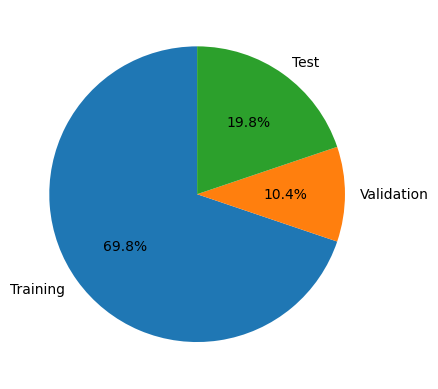

In [ ]:
training_files_count = (tf.data.experimental.cardinality(train_ds) * batch_size).numpy()
validation_files_count = (tf.data.experimental.cardinality(val_ds) * batch_size).numpy()
testing_files_count = (tf.data.experimental.cardinality(test_ds) * batch_size).numpy()

labels = ['Training', 'Validation', 'Test']
sizes = [training_files_count, validation_files_count, testing_files_count]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

## Visualise labels distribution

We visualise label distribution for the validation and test sets to make sure this has been maintained proportional during the dataset split.

We gather the labels for all the images in the validation set. Then we count the ocurrances of each one and draw a graph to visualise them.

In [ ]:
def plotLabelDistribution(labels_list):
  val_labels_df = pd.DataFrame(labels_list, columns =['Labels'])
  val_labels_df['Labels'] = val_labels_df['Labels'].map(lambda label_int: class_names[label_int])

  #calculate value counts (distribution) and display
  val_labels_distribution = val_labels_df['Labels'].value_counts()

  val_labels_distribution.index.to_numpy()
  val_labels_distribution.array.to_numpy()

  fig, ax = plt.subplots(figsize=(9, 5))

  container = ax.bar(val_labels_distribution.index.to_numpy(), val_labels_distribution.array.to_numpy())
  ax.bar_label(container, label_type='center')

  ax.set_ylabel('Count')
  ax.set_title('Categories')

  plt.show()



### Validation Labels Distribution

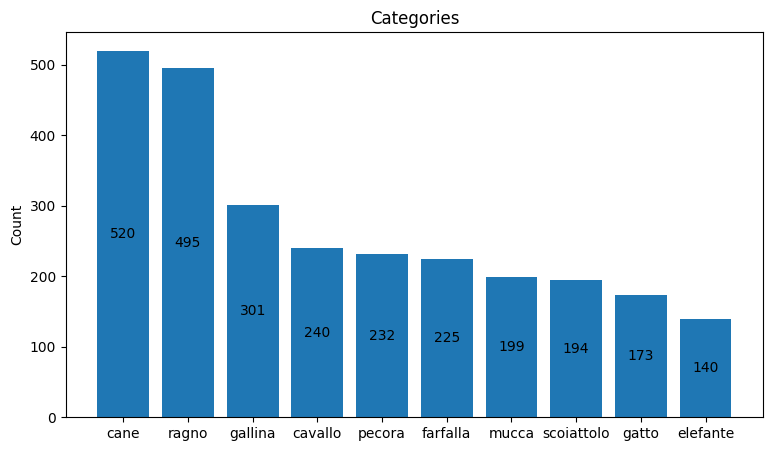

In [ ]:
#gather all the labels in a single list
labels_list = []
for batch in val_ds.as_numpy_iterator():
  (images, labels) = batch
  labels_list.extend(labels)

plotLabelDistribution(labels_list)

### Test Labels Distribution

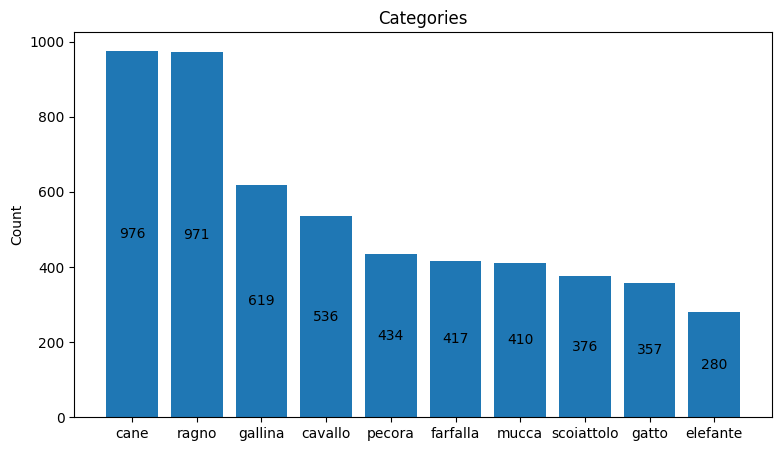

In [ ]:
#gather all the labels in a single list
labels_list = []
for batch in test_ds.as_numpy_iterator():
  (images, labels) = batch
  labels_list.extend(labels)

plotLabelDistribution(labels_list)

## Visualise a few images

We visualise a few images from the training set to validate that all looks good at this point and the labels match the animals in the pictures.

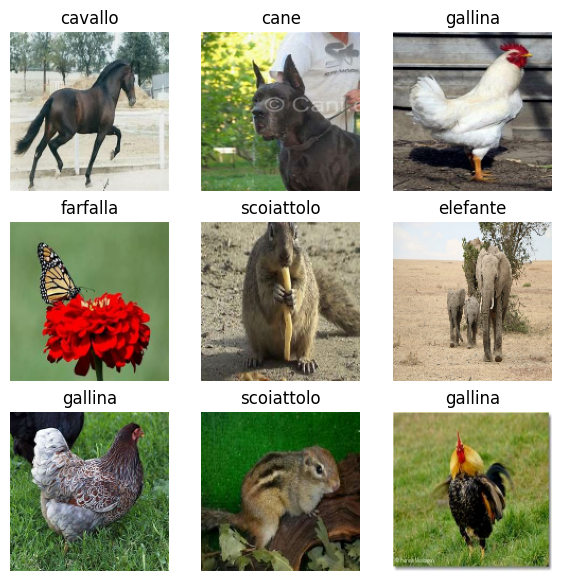

In [ ]:
plt.figure(figsize=(7, 7))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
class_names

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

## Configure and preprocess the datasets

### Prefetching for performance

The datasets are configured to handle prefetching of images asynchronously to speed up training by loading images before they are needed.

See: https://www.tensorflow.org/guide/data_performance

In [6]:
#Configure datasets for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


### Validate tensor shapes

Batch should have following shapes:
- Images (128, 150, 150, 3)
  *   128 is the batch size
  *   150, 150 is the image size
  *   3 is the number of colour channels (RGB)
- Labels (128, ) 1 label per image in the batch (128)


We also visualise that the labels are integers values ranging from 0-9, they need to be converted to categorical values next



In [ ]:
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  print(labels_batch)
  break


(128, 150, 150, 3)
(128,)
tf.Tensor(
[9 0 0 1 7 4 4 4 8 9 7 0 7 1 3 7 7 2 8 0 5 5 0 8 6 1 8 4 6 8 8 4 6 6 5 0 8
 0 0 6 8 4 5 8 5 6 8 7 7 7 8 2 8 6 8 8 6 5 8 8 9 4 7 8 0 1 3 9 0 4 3 2 5 9
 0 3 2 0 7 5 7 0 0 8 3 6 4 5 0 3 9 2 5 8 1 3 9 8 5 0 3 7 8 0 4 7 8 0 3 4 6
 4 8 3 0 4 3 7 1 1 0 8 3 6 0 8 7 8], shape=(128,), dtype=int32)


### Converting Labels to Categorical one-hot encodings

We map the datasets using a function which turns labels into categorical encodings. We then visualise the labels in a batch to validate that they are now indeed hot-encoded vectors made ups of zeros and ones.

In [7]:
#Transform labels to one-hot encoded vectors
def labelToCategorical(img, label):
  label = tf.one_hot(tf.cast(label, tf.uint8), num_classes)
  return img, label

processed_train_ds = train_ds.map(labelToCategorical)
processed_val_ds = val_ds.map(labelToCategorical)
processed_test_ds = test_ds.map(labelToCategorical)

for image_batch, labels_batch in processed_test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  print(labels_batch)
  break


(128, 150, 150, 3)
(128, 10)
tf.Tensor(
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]], shape=(128, 10), dtype=float32)


## Define Model Evaluation and Visualisation Functions

These functions will be used later for each of our models in order to visualise their performance.

They are created in advanced so as to keep things organised and easy to reference later in case we need to update any of these functions.

### Functions to plot validation Loss and Accuracy

The following functions plot the validation loss and accuracy of a given model's history. This will be used to analyse the models' performances.

In [8]:
#The following function is an adaptation of the code shown in the lectures of
#module CM3015.
def plot_epochs(x, graphs,
                title, x_label, y_label):

  plt.clf()
  for g in graphs:
    plt.plot(x, g['ys'], g['style'], label = g['label'])

  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()

def plot_val_loss_and_accuracy(history):
  history_dict = history.history

  graphs = [{"ys": history_dict['loss'],
             "style": 'bo',
             "label": 'Training'},
            {"ys": history_dict['val_loss'],
             "style": 'b',
             "label": 'Validation'}]
  plot_epochs(range(1, len(history_dict['loss']) + 1),
            graphs, 'Training and validation loss',
            'Epochs', 'Loss')

  print("Ideal epoch for validation loss: ", np.argmin(history_dict['val_loss']) + 1, 'epochs')
  print("Validation loss: ", history_dict['val_loss'][np.argmin(history_dict['val_loss'])])

  graphs = [{"ys": history_dict['accuracy'],
             "style": 'ro',
             "label": 'Training'},
            {"ys": history_dict['val_accuracy'],
             "style": 'r',
             "label": 'Validation'}]
  plot_epochs(range(1, len(history_dict['accuracy']) + 1),
              graphs, 'Training and validation accuracy',
              'Epochs', 'Accuracy')

  print("Ideal epoch for validation accuracy: ", np.argmax(history_dict['val_accuracy']) + 1, 'epochs')
  print("Validation accuracy: ", history_dict['val_accuracy'][np.argmax(history_dict['val_accuracy'])])

### Functions to display Confusion Matrix and Classification Report

The following functions are used to display a confusion matrix based on a model's predictions, and to display a classification report with all the key metrics to look at regarding the model's performances.



In [9]:
def displayConfusionMatrix(predictions, dataset):
  #Get true labels from dataset
  labels =  np.array([])
  for x, y in dataset:
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

  fig, ax = plt.subplots(figsize=(8,8))
  ConfusionMatrixDisplay.from_predictions(
      labels, np.argmax(predictions, axis=1),
      display_labels=class_names, cmap=plt.cm.Blues,
      ax=ax, xticks_rotation="vertical", normalize='pred')

def displayClassificationReport(predictions, dataset):
  #Get true labels from dataset
  labels =  np.array([])
  for x, y in dataset:
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

  cr = metrics.classification_report(
    labels,
    np.argmax(predictions, axis=1),
    target_names=class_names
  )

  print(cr)

In [10]:
def evaluateModelsPerformance(model, model_history, test_dataset):
  plot_val_loss_and_accuracy(model_history)
  predictions = model.predict(test_dataset)
  displayConfusionMatrix(predictions, test_dataset)
  displayClassificationReport(predictions, test_dataset)

## Multilayer Perceptron / Densely Connected Neural Network (DNN)

Below is the code to create and run the DNN network. It is meant to be used as a baseline to be compared with the CNN network we will create afterwards.

In [ ]:
dnn_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(150,150,3)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

dnn_model.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=['accuracy'])

dnn_history = dnn_model.fit(
  processed_train_ds,
  validation_data=processed_val_ds,
  epochs=20
)

Epoch 1/20
148/148 [==============================] - 77s 507ms/step - loss: 6.3396 - accuracy: 0.1953 - val_loss: 2.0709 - val_accuracy: 0.2497
Epoch 2/20
148/148 [==============================] - 73s 493ms/step - loss: 2.0342 - accuracy: 0.2615 - val_loss: 1.9769 - val_accuracy: 0.2924
Epoch 3/20
148/148 [==============================] - 73s 493ms/step - loss: 1.9619 - accuracy: 0.2982 - val_loss: 1.9215 - val_accuracy: 0.3244
Epoch 4/20
148/148 [==============================] - 73s 493ms/step - loss: 1.9160 - accuracy: 0.3158 - val_loss: 1.8750 - val_accuracy: 0.3420
Epoch 5/20
148/148 [==============================] - 73s 493ms/step - loss: 1.8919 - accuracy: 0.3201 - val_loss: 1.8888 - val_accuracy: 0.3465
Epoch 6/20
148/148 [==============================] - 73s 492ms/step - loss: 1.8629 - accuracy: 0.3336 - val_loss: 1.8450 - val_accuracy: 0.3531
Epoch 7/20
148/148 [==============================] - 73s 495ms/step - loss: 1.8425 - accuracy: 0.3416 - val_loss: 1.8465 - val_ac

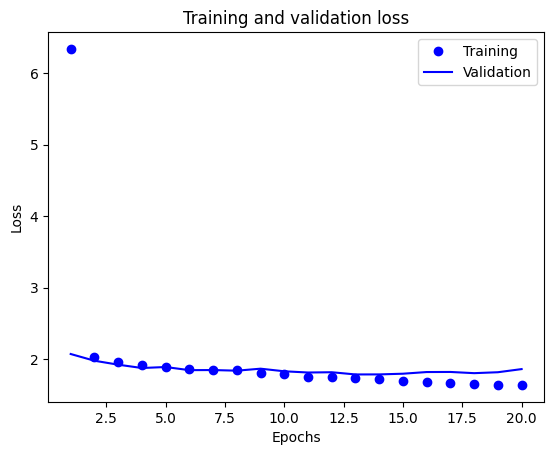

Ideal epoch for validation loss:  13 epochs
Validation loss:  1.7848591804504395


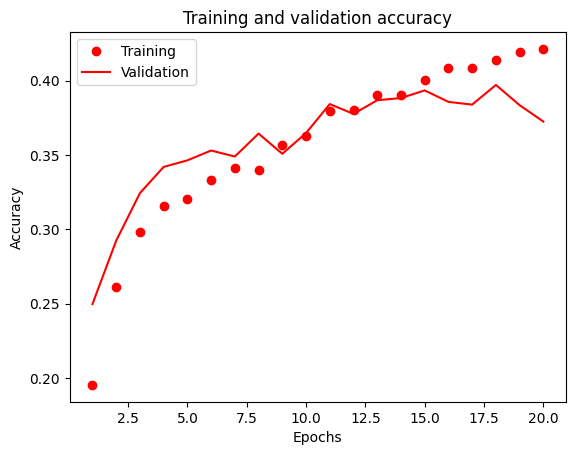

Ideal epoch for validation accuracy:  18 epochs
Validation accuracy:  0.39720484614372253
42/42 [==============================] - 2s 58ms/step
              precision    recall  f1-score   support

        cane       0.32      0.41      0.36       981
     cavallo       0.36      0.55      0.43       538
    elefante       0.18      0.08      0.11       290
    farfalla       0.38      0.28      0.33       410
     gallina       0.34      0.25      0.29       615
       gatto       0.34      0.04      0.07       359
       mucca       0.34      0.33      0.33       407
      pecora       0.39      0.25      0.31       444
       ragno       0.43      0.66      0.52       962
  scoiattolo       0.28      0.16      0.21       370

    accuracy                           0.36      5376
   macro avg       0.34      0.30      0.29      5376
weighted avg       0.35      0.36      0.34      5376



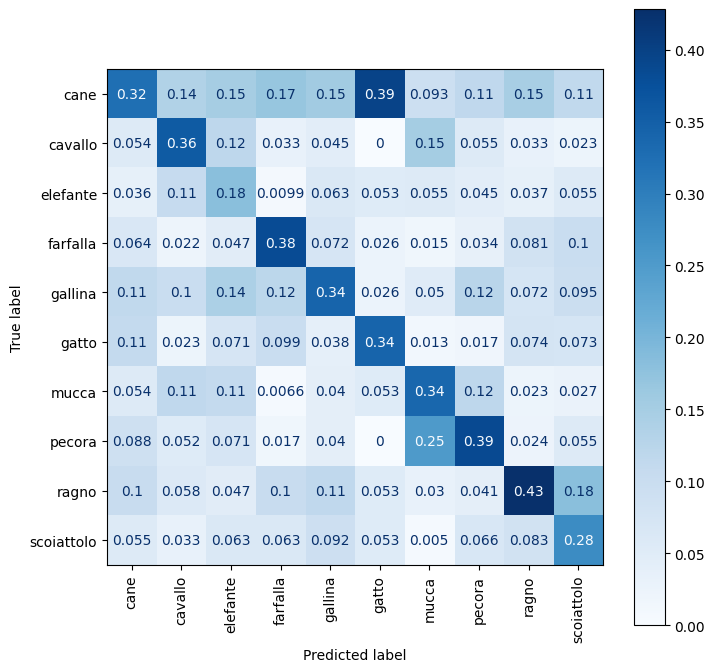

In [ ]:
evaluateModelsPerformance(dnn_model, dnn_history, processed_test_ds)

We can see that the network is not learning the training set very well. It is also starting to overfit at the end.

I will try increase its capacity to see if I can improve its performance while also increasing dropout rate to address overfitting.

## DNN 2: Increase capacity and training time

- Add one more 2048 layer
- Increase dropout rate to 0.1 on every dropout layer
- Train for longer (30 epochs)

In [11]:
dnn_model_2 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(150,150,3)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

dnn_model_2.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=['accuracy'])

dnn_model_2_history = dnn_model_2.fit(
  processed_train_ds,
  validation_data=processed_val_ds,
  epochs=20
)

Epoch 1/20
148/148 [==============================] - 225s 1s/step - loss: 4.7609 - accuracy: 0.1951 - val_loss: 2.1097 - val_accuracy: 0.2479
Epoch 2/20
148/148 [==============================] - 108s 730ms/step - loss: 2.0737 - accuracy: 0.2499 - val_loss: 2.0111 - val_accuracy: 0.2784
Epoch 3/20
148/148 [==============================] - 110s 740ms/step - loss: 1.9981 - accuracy: 0.2771 - val_loss: 1.9481 - val_accuracy: 0.2946
Epoch 4/20
148/148 [==============================] - 88s 597ms/step - loss: 1.9707 - accuracy: 0.2919 - val_loss: 1.9381 - val_accuracy: 0.2994
Epoch 5/20
148/148 [==============================] - 87s 586ms/step - loss: 1.9368 - accuracy: 0.3087 - val_loss: 1.9240 - val_accuracy: 0.3089
Epoch 6/20
148/148 [==============================] - 86s 582ms/step - loss: 1.9171 - accuracy: 0.3146 - val_loss: 1.9304 - val_accuracy: 0.3233
Epoch 7/20
148/148 [==============================] - 88s 593ms/step - loss: 1.9035 - accuracy: 0.3230 - val_loss: 1.8753 - val_ac

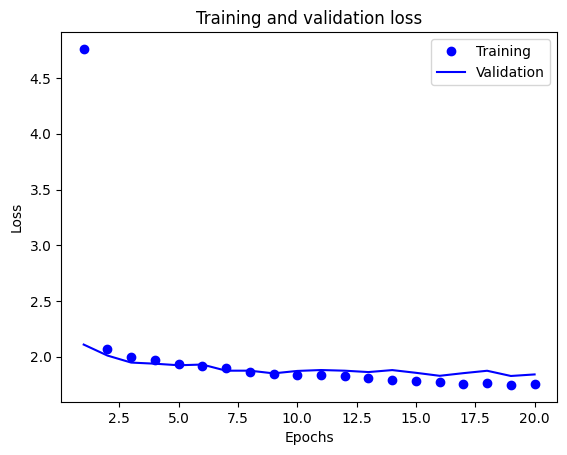

Ideal epoch for validation loss:  19 epochs
Validation loss:  1.827888011932373


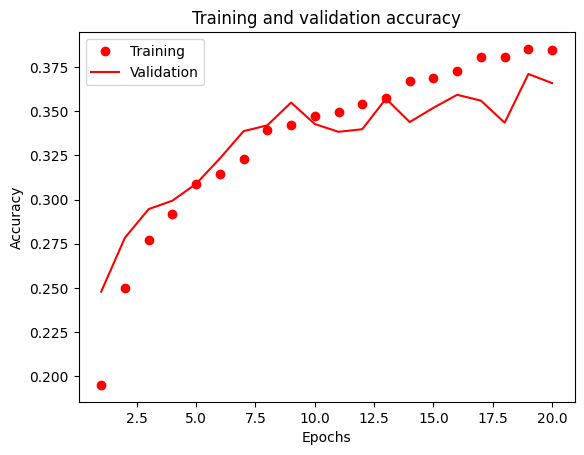

Ideal epoch for validation accuracy:  19 epochs
Validation accuracy:  0.3710923194885254
42/42 [==============================] - 5s 110ms/step
              precision    recall  f1-score   support

        cane       0.28      0.62      0.39       982
     cavallo       0.39      0.34      0.36       536
    elefante       0.33      0.05      0.09       300
    farfalla       0.64      0.23      0.34       416
     gallina       0.35      0.40      0.37       611
       gatto       0.40      0.02      0.03       361
       mucca       0.31      0.33      0.32       399
      pecora       0.36      0.32      0.34       433
       ragno       0.51      0.48      0.49       969
  scoiattolo       0.13      0.04      0.07       369

    accuracy                           0.35      5376
   macro avg       0.37      0.28      0.28      5376
weighted avg       0.38      0.35      0.33      5376



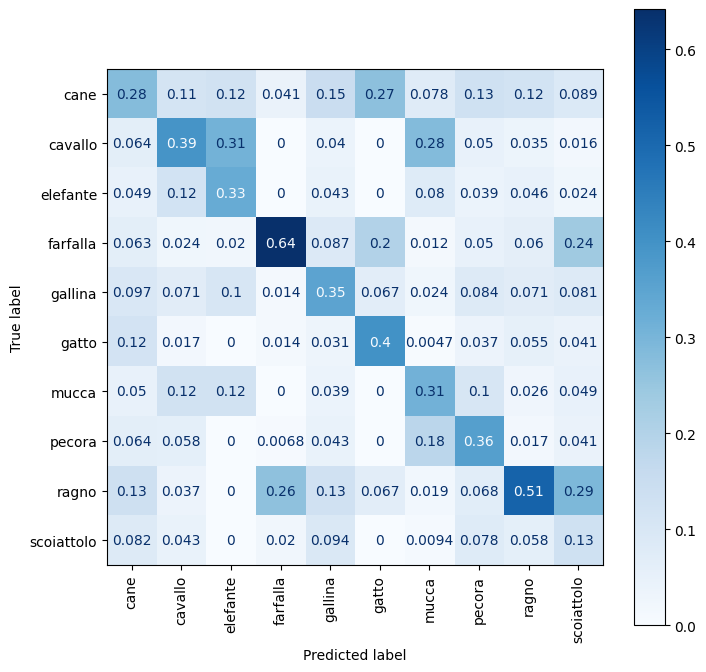

In [12]:
evaluateModelsPerformance(dnn_model_2, dnn_model_2_history, processed_test_ds)

We can see that the network is now performing worse than before.
I do not think this network can be improved by simply adding layers to it or increasing capacity.

I'll take the first DNN network we did as a baseline and move on to try more advanced architectures which are more suited for image data.

## Convolutional Neural Networks (CNN)

First attempt at a CNN, aiming to overfit first and then optimise.

In [ ]:
cnn_model = tf.keras.models.Sequential()

cnn_model.add(tf.keras.layers.Rescaling(1./255, input_shape=(150,150,3)))

cnn_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(2))

cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(2))

cnn_model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(2))

cnn_model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(2))

cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(256, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(10, activation='softmax'))

cnn_model.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=['accuracy'])

cnn_history = cnn_model.fit(
  processed_train_ds,
  validation_data=processed_val_ds,
  epochs=20
)

Epoch 1/20
148/148 [==============================] - 120s 803ms/step - loss: 1.9356 - accuracy: 0.3163 - val_loss: 1.6038 - val_accuracy: 0.4413
Epoch 2/20
148/148 [==============================] - 116s 785ms/step - loss: 1.4213 - accuracy: 0.5145 - val_loss: 1.2893 - val_accuracy: 0.5598
Epoch 3/20
148/148 [==============================] - 115s 779ms/step - loss: 1.1686 - accuracy: 0.6044 - val_loss: 1.1735 - val_accuracy: 0.6120
Epoch 4/20
148/148 [==============================] - 115s 776ms/step - loss: 1.0036 - accuracy: 0.6606 - val_loss: 1.0550 - val_accuracy: 0.6528
Epoch 5/20
148/148 [==============================] - 115s 780ms/step - loss: 0.8741 - accuracy: 0.7069 - val_loss: 1.0547 - val_accuracy: 0.6410
Epoch 6/20
148/148 [==============================] - 114s 768ms/step - loss: 0.7781 - accuracy: 0.7374 - val_loss: 1.0558 - val_accuracy: 0.6433
Epoch 7/20
148/148 [==============================] - 113s 764ms/step - loss: 0.6935 - accuracy: 0.7667 - val_loss: 1.0735 -

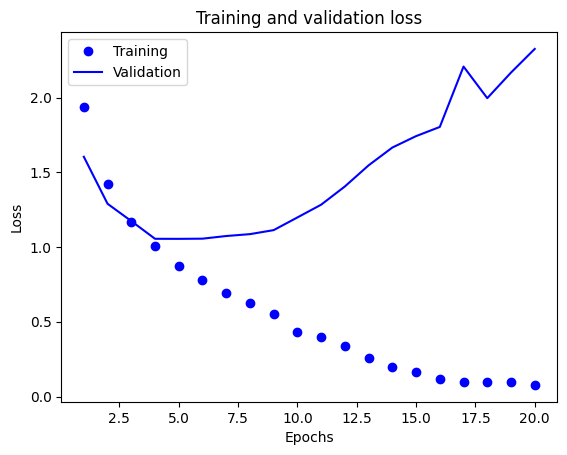

Ideal epoch for validation loss:  5 epochs
Validation loss:  1.0546574592590332


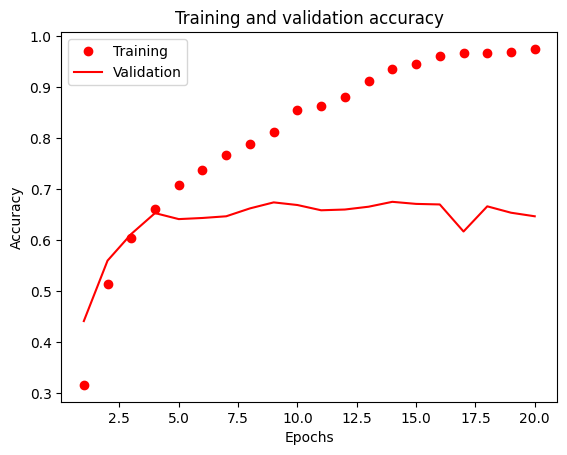

Ideal epoch for validation accuracy:  14 epochs
Validation accuracy:  0.6748804450035095
42/42 [==============================] - 7s 162ms/step
              precision    recall  f1-score   support

        cane       0.62      0.62      0.62       981
     cavallo       0.66      0.62      0.63       538
    elefante       0.70      0.37      0.48       290
    farfalla       0.79      0.60      0.69       410
     gallina       0.66      0.79      0.72       615
       gatto       0.44      0.42      0.43       359
       mucca       0.44      0.66      0.53       407
      pecora       0.66      0.53      0.59       444
       ragno       0.75      0.84      0.79       962
  scoiattolo       0.54      0.44      0.49       370

    accuracy                           0.63      5376
   macro avg       0.63      0.59      0.60      5376
weighted avg       0.64      0.63      0.63      5376



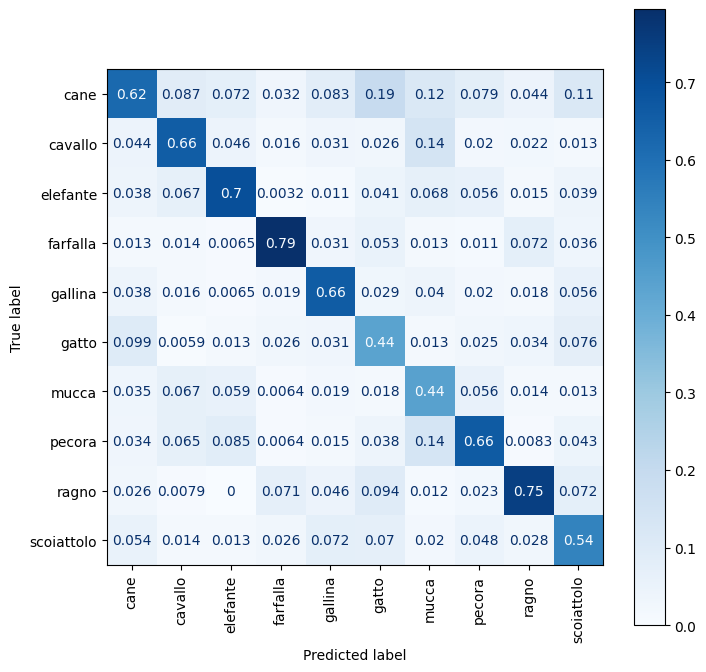

In [ ]:
evaluateModelsPerformance(cnn_model, cnn_history, processed_test_ds)

### CNN 1 Evaluation
Much better results than the DNN network, but heavy overfitting happening.
We need to try regularisation techniques.

## CNN Network 2: Adding dropout regularisation to address overfitting.

Dropout layers have been added throughout the network.

In [ ]:
cnn_model_2 = tf.keras.models.Sequential()

cnn_model_2.add(tf.keras.layers.Rescaling(1./255, input_shape=(150,150,3)))

cnn_model_2.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_2.add(tf.keras.layers.MaxPooling2D(2))
cnn_model_2.add(tf.keras.layers.Dropout(0.4))

cnn_model_2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model_2.add(tf.keras.layers.MaxPooling2D(2))
cnn_model_2.add(tf.keras.layers.Dropout(0.4))

cnn_model_2.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model_2.add(tf.keras.layers.MaxPooling2D(2))
cnn_model_2.add(tf.keras.layers.Dropout(0.4))


cnn_model_2.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model_2.add(tf.keras.layers.MaxPooling2D(2))
cnn_model_2.add(tf.keras.layers.Dropout(0.4))

cnn_model_2.add(tf.keras.layers.Flatten())
cnn_model_2.add(tf.keras.layers.Dropout(0.2))
cnn_model_2.add(tf.keras.layers.Dense(256, activation='relu'))
cnn_model_2.add(tf.keras.layers.Dense(10, activation='softmax'))

cnn_model_2.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=['accuracy'])

cnn_model_2_history = cnn_model_2.fit(
  processed_train_ds,
  validation_data=processed_val_ds,
  epochs=20
)

Epoch 1/20
148/148 [==============================] - 124s 823ms/step - loss: 2.1401 - accuracy: 0.2309 - val_loss: 2.0175 - val_accuracy: 0.3288
Epoch 2/20
148/148 [==============================] - 126s 850ms/step - loss: 1.8017 - accuracy: 0.3696 - val_loss: 1.7323 - val_accuracy: 0.4502
Epoch 3/20
148/148 [==============================] - 123s 831ms/step - loss: 1.5502 - accuracy: 0.4669 - val_loss: 1.4508 - val_accuracy: 0.5355
Epoch 4/20
148/148 [==============================] - 121s 817ms/step - loss: 1.3629 - accuracy: 0.5357 - val_loss: 1.3453 - val_accuracy: 0.5480
Epoch 5/20
148/148 [==============================] - 121s 820ms/step - loss: 1.2434 - accuracy: 0.5768 - val_loss: 1.2858 - val_accuracy: 0.5715
Epoch 6/20
148/148 [==============================] - 121s 820ms/step - loss: 1.1612 - accuracy: 0.6040 - val_loss: 1.2404 - val_accuracy: 0.5748
Epoch 7/20
148/148 [==============================] - 121s 818ms/step - loss: 1.0838 - accuracy: 0.6265 - val_loss: 1.2070 -

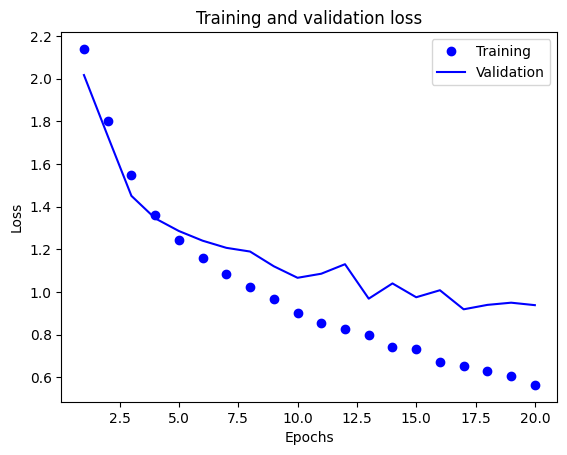

Ideal epoch for validation loss:  17 epochs
Validation loss:  0.9185688495635986


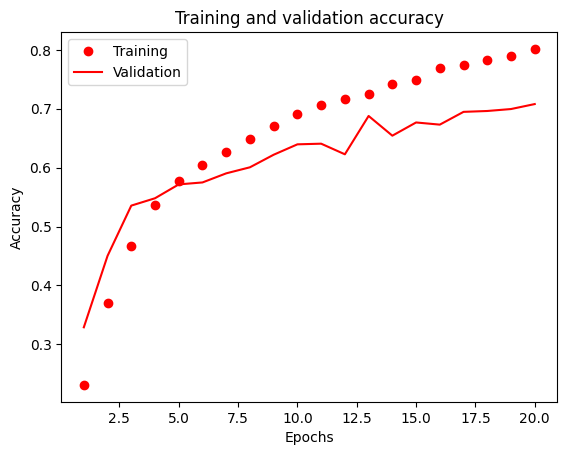

Ideal epoch for validation accuracy:  20 epochs
Validation accuracy:  0.7079808712005615
42/42 [==============================] - 7s 165ms/step
              precision    recall  f1-score   support

        cane       0.65      0.75      0.70       981
     cavallo       0.69      0.73      0.71       538
    elefante       0.65      0.67      0.66       290
    farfalla       0.85      0.74      0.79       410
     gallina       0.80      0.80      0.80       615
       gatto       0.58      0.37      0.45       359
       mucca       0.73      0.49      0.59       407
      pecora       0.71      0.69      0.70       444
       ragno       0.79      0.88      0.84       962
  scoiattolo       0.63      0.66      0.65       370

    accuracy                           0.72      5376
   macro avg       0.71      0.68      0.69      5376
weighted avg       0.72      0.72      0.71      5376



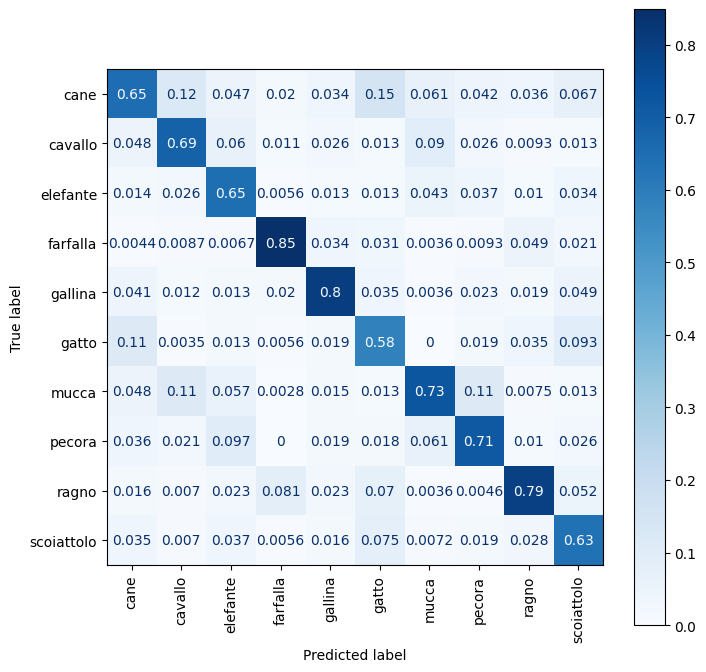

In [ ]:
evaluateModelsPerformance(cnn_model_2, cnn_model_2_history, processed_test_ds)

### CNN 2 Evaluation

Dropout really helped reduce overfitting. Better F1 score achieved compared with CNN network without dropout layers.

## CNN Network 3: Using Data Augmentation

I will try anther technique that helps overfitting and will compare it to dropout. The technique is data augmentation.

### Set up data augmentation layers and visualising it

Below I setup a data augmentation set of layers which will be used to modify images in the dataset.

I also define a function that, given an image, it will create a few augmentations and display them in order for me to verify that everything is working as expected.

In [15]:
#Setup data augmentation layer
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomTranslation(0.2,0.2,'nearest'),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomBrightness(0.2),
])


In [ ]:
def visualize_augmentations(original, augmentation_layer):

  #Show original image
  fig = plt.figure(figsize=(2, 2))
  plt.title('Original image')
  plt.imshow(original.numpy().astype("uint8"))

  #create 9 random augmentations and display them
  plt.figure(figsize=(6, 6))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented = data_augmentation(original)
    plt.imshow(augmented.numpy().astype("uint8"))
    plt.title("augmentation " + str(i+1))
    plt.axis("off")

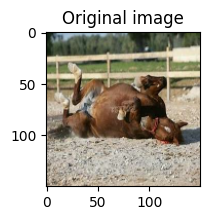

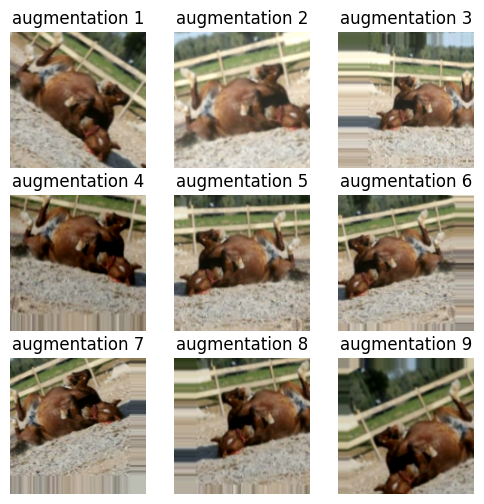

In [ ]:
#Fetch random image and generate augmentations for testing
random_image = None
random_label= None

for image, label in train_ds.unbatch().take(1):
  random_image = image
  random_label = label

visualize_augmentations(random_image, data_augmentation)

In [ ]:
cnn_model_aug_1 = tf.keras.models.Sequential()

#data augmentation and rescaling
cnn_model_aug_1.add(data_augmentation)
cnn_model_aug_1.add(tf.keras.layers.Rescaling(1./255))

cnn_model_aug_1.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_aug_1.add(tf.keras.layers.MaxPooling2D(2))

cnn_model_aug_1.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model_aug_1.add(tf.keras.layers.MaxPooling2D(2))

cnn_model_aug_1.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model_aug_1.add(tf.keras.layers.MaxPooling2D(2))

cnn_model_aug_1.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model_aug_1.add(tf.keras.layers.MaxPooling2D(2))

cnn_model_aug_1.add(tf.keras.layers.Flatten())
cnn_model_aug_1.add(tf.keras.layers.Dense(256, activation='relu'))
cnn_model_aug_1.add(tf.keras.layers.Dense(10, activation='softmax'))

cnn_model_aug_1.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=['accuracy'])

cnn_model_aug_1_history = cnn_model_aug_1.fit(
  processed_train_ds,
  validation_data=processed_val_ds,
  epochs=20
)

Epoch 1/20
148/148 [==============================] - 122s 810ms/step - loss: 2.0777 - accuracy: 0.2499 - val_loss: 2.2031 - val_accuracy: 0.2644
Epoch 2/20
148/148 [==============================] - 119s 804ms/step - loss: 1.7911 - accuracy: 0.3763 - val_loss: 1.9849 - val_accuracy: 0.3225
Epoch 3/20
148/148 [==============================] - 119s 802ms/step - loss: 1.6326 - accuracy: 0.4415 - val_loss: 1.8153 - val_accuracy: 0.3891
Epoch 4/20
148/148 [==============================] - 119s 804ms/step - loss: 1.5031 - accuracy: 0.4866 - val_loss: 1.6305 - val_accuracy: 0.4553
Epoch 5/20
148/148 [==============================] - 120s 809ms/step - loss: 1.4066 - accuracy: 0.5245 - val_loss: 1.5379 - val_accuracy: 0.4667
Epoch 6/20
148/148 [==============================] - 119s 807ms/step - loss: 1.3064 - accuracy: 0.5546 - val_loss: 1.4256 - val_accuracy: 0.5116
Epoch 7/20
148/148 [==============================] - 120s 808ms/step - loss: 1.2599 - accuracy: 0.5716 - val_loss: 1.2863 -

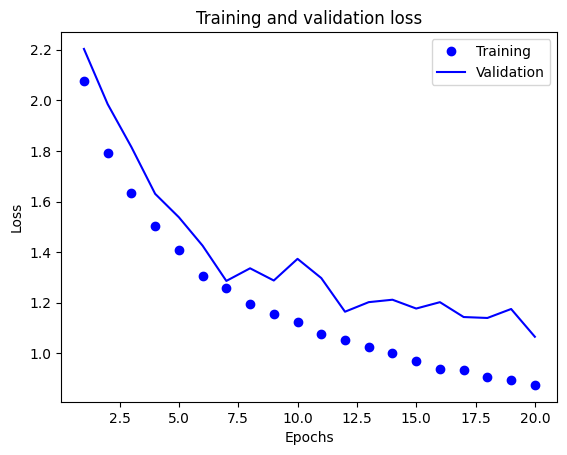

Ideal epoch for validation loss:  20 epochs
Validation loss:  1.0657384395599365


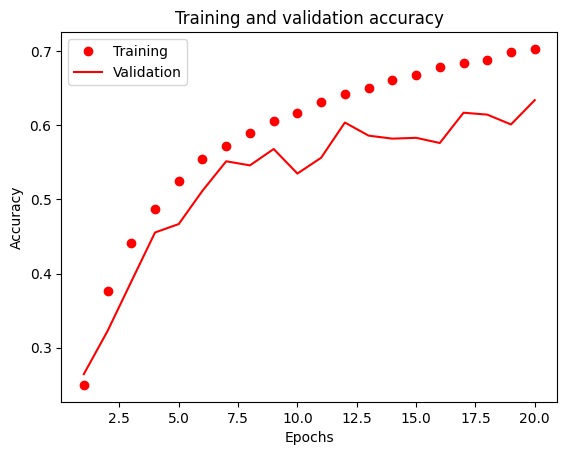

Ideal epoch for validation accuracy:  20 epochs
Validation accuracy:  0.6336888670921326
42/42 [==============================] - 7s 163ms/step
              precision    recall  f1-score   support

        cane       0.71      0.62      0.66       981
     cavallo       0.73      0.65      0.68       538
    elefante       0.42      0.79      0.55       290
    farfalla       0.55      0.89      0.68       410
     gallina       0.70      0.84      0.77       615
       gatto       0.58      0.40      0.47       359
       mucca       0.66      0.41      0.51       407
      pecora       0.54      0.58      0.56       444
       ragno       0.83      0.74      0.78       962
  scoiattolo       0.67      0.48      0.56       370

    accuracy                           0.65      5376
   macro avg       0.64      0.64      0.62      5376
weighted avg       0.67      0.65      0.65      5376



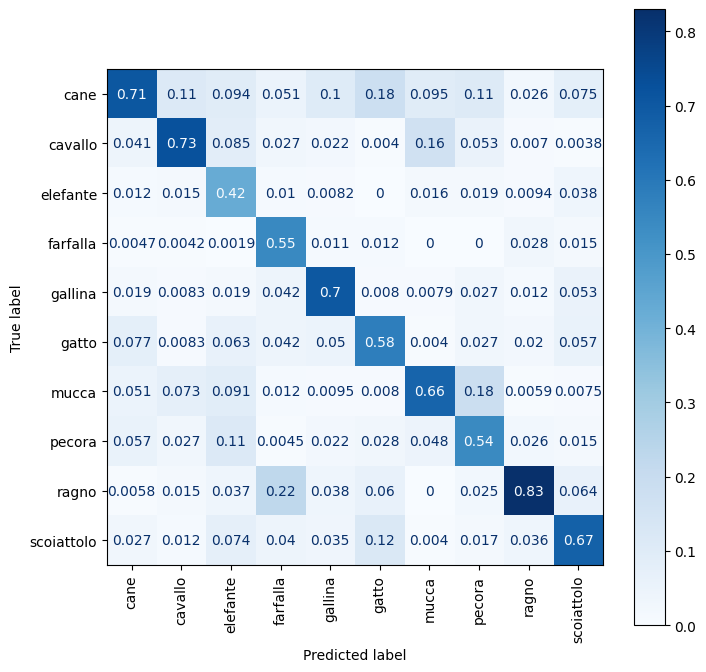

In [ ]:
evaluateModelsPerformance(cnn_model_aug_1, cnn_model_aug_1_history, processed_test_ds)

### CNN 3 Evaluation

Data augmentation has had a detrimental effect on performance. It seems to have reduced the ability of the network to learn the dataset. This makes sense as the network never sees the same image twice now.

I will try it again but this time I won't augment the validation set, only the training set. I will do this by removing the data augmentation layers from the network itself and instead applying this to the training set only before it is fed into the network.

## CNN 4: Data augmentation of training set only.

Validation loss and accuracy seem quite unstable. Perhaps because the validation dataset is also augmented, since augmentation layers are built into the network.
I will try try only augmenting the training set. I can also see some overfitting in the graph and the overall accuracy is worse than without augmentation.

I will also increase the capcity of the classifier from 256 units to 512 as the previous network didn't learn the training set very well.

In [16]:
processed_augmented_train_ds = processed_train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
processed_augmented_train_ds = processed_augmented_train_ds.prefetch(buffer_size=AUTOTUNE)



In [ ]:
cnn_model_aug_2 = tf.keras.models.Sequential()
cnn_model_aug_2.add(tf.keras.layers.Rescaling(1./255))

cnn_model_aug_2.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_aug_2.add(tf.keras.layers.MaxPooling2D(2))

cnn_model_aug_2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model_aug_2.add(tf.keras.layers.MaxPooling2D(2))

cnn_model_aug_2.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model_aug_2.add(tf.keras.layers.MaxPooling2D(2))

cnn_model_aug_2.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model_aug_2.add(tf.keras.layers.MaxPooling2D(2))

cnn_model_aug_2.add(tf.keras.layers.Flatten())
cnn_model_aug_2.add(tf.keras.layers.Dense(512, activation='relu'))
cnn_model_aug_2.add(tf.keras.layers.Dense(10, activation='softmax'))

cnn_model_aug_2.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=['accuracy'])

#notice the augmented train data. The network itself doesn't include augmentation layers.
cnn_model_aug_2_history = cnn_model_aug_2.fit(
  processed_augmented_train_ds,
  validation_data=processed_val_ds,
  epochs=20
)

Epoch 1/20
148/148 [==============================] - 122s 808ms/step - loss: 2.0725 - accuracy: 0.2535 - val_loss: 2.1560 - val_accuracy: 0.2766
Epoch 2/20
148/148 [==============================] - 121s 807ms/step - loss: 1.7934 - accuracy: 0.3751 - val_loss: 1.9310 - val_accuracy: 0.3623
Epoch 3/20
148/148 [==============================] - 121s 811ms/step - loss: 1.6052 - accuracy: 0.4469 - val_loss: 1.6891 - val_accuracy: 0.4167
Epoch 4/20
148/148 [==============================] - 123s 823ms/step - loss: 1.4698 - accuracy: 0.4944 - val_loss: 1.5142 - val_accuracy: 0.4847
Epoch 5/20
148/148 [==============================] - 121s 812ms/step - loss: 1.3728 - accuracy: 0.5293 - val_loss: 1.5357 - val_accuracy: 0.4689
Epoch 6/20
148/148 [==============================] - 123s 819ms/step - loss: 1.2929 - accuracy: 0.5598 - val_loss: 1.4115 - val_accuracy: 0.5050
Epoch 7/20
148/148 [==============================] - 122s 817ms/step - loss: 1.2474 - accuracy: 0.5781 - val_loss: 1.2650 -

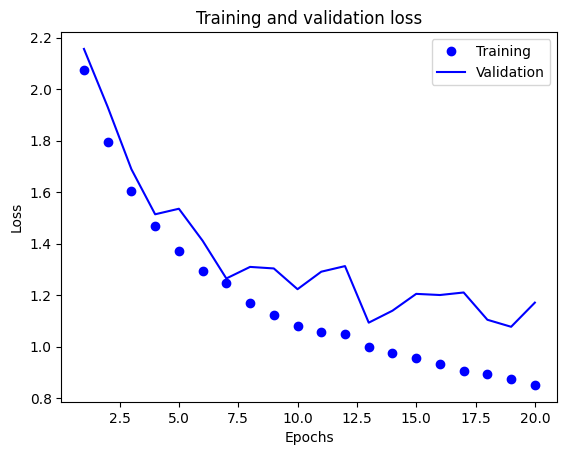

Ideal epoch for validation loss:  19 epochs
Validation loss:  1.0775132179260254


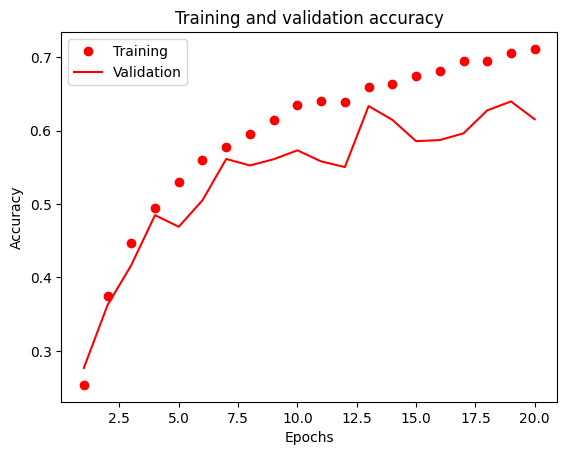

Ideal epoch for validation accuracy:  19 epochs
Validation accuracy:  0.6395733952522278
42/42 [==============================] - 7s 172ms/step
              precision    recall  f1-score   support

        cane       0.78      0.53      0.63       981
     cavallo       0.69      0.66      0.67       538
    elefante       0.62      0.67      0.65       290
    farfalla       0.48      0.93      0.63       410
     gallina       0.57      0.87      0.69       615
       gatto       0.59      0.38      0.46       359
       mucca       0.70      0.43      0.53       407
      pecora       0.49      0.80      0.61       444
       ragno       0.93      0.55      0.69       962
  scoiattolo       0.54      0.56      0.55       370

    accuracy                           0.63      5376
   macro avg       0.64      0.64      0.61      5376
weighted avg       0.68      0.63      0.63      5376



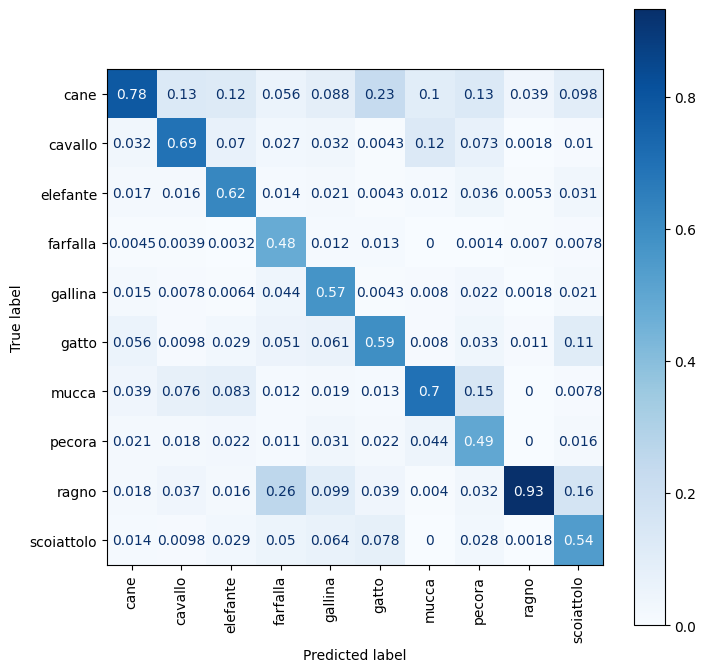

In [ ]:
evaluateModelsPerformance(cnn_model_aug_2, cnn_model_aug_2_history, processed_test_ds)

### CNN 4 Evaluation

Very similar results. I am going to try increasing the network capacity and train for longer to see if I can improve the performance

## CNN 5: Data augmentation of training set only but more capacity.


Changes to previous network:

1. Increase the number of dense layers in the backend of the network.
2. Increase the number of units in the dense layers to 1024.
3. Train for 40 epochs.
4. Add dropout layers in between the dense layers to help with overfitting.

In [ ]:
cnn_model_aug_3 = tf.keras.models.Sequential()
cnn_model_aug_3.add(tf.keras.layers.Rescaling(1./255))

cnn_model_aug_3.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_aug_3.add(tf.keras.layers.MaxPooling2D(2))

cnn_model_aug_3.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model_aug_3.add(tf.keras.layers.MaxPooling2D(2))

cnn_model_aug_3.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model_aug_3.add(tf.keras.layers.MaxPooling2D(2))

cnn_model_aug_3.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model_aug_3.add(tf.keras.layers.MaxPooling2D(2))

cnn_model_aug_3.add(tf.keras.layers.Flatten())
cnn_model_aug_3.add(tf.keras.layers.Dense(1024, activation='relu'))
cnn_model_aug_3.add(tf.keras.layers.Dropout(0.2))

cnn_model_aug_3.add(tf.keras.layers.Dense(1024, activation='relu'))
cnn_model_aug_3.add(tf.keras.layers.Dropout(0.2))

cnn_model_aug_3.add(tf.keras.layers.Dense(1024, activation='relu'))
cnn_model_aug_3.add(tf.keras.layers.Dense(10, activation='softmax'))

cnn_model_aug_3.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=['accuracy'])

#notice the augmented train data. The network itself doesn't include augmentation layers.
cnn_model_aug_3_history = cnn_model_aug_3.fit(
  processed_augmented_train_ds,
  validation_data=processed_val_ds,
  epochs=40
)

Epoch 1/40
148/148 [==============================] - 198s 1s/step - loss: 2.1752 - accuracy: 0.2097 - val_loss: 2.3685 - val_accuracy: 0.2284
Epoch 2/40
148/148 [==============================] - 132s 880ms/step - loss: 1.9443 - accuracy: 0.3157 - val_loss: 2.2917 - val_accuracy: 0.2545
Epoch 3/40
148/148 [==============================] - 132s 882ms/step - loss: 1.7423 - accuracy: 0.4002 - val_loss: 2.6681 - val_accuracy: 0.2291
Epoch 4/40
148/148 [==============================] - 134s 892ms/step - loss: 1.5793 - accuracy: 0.4579 - val_loss: 2.2043 - val_accuracy: 0.3259
Epoch 5/40
148/148 [==============================] - 132s 883ms/step - loss: 1.4673 - accuracy: 0.4990 - val_loss: 1.9035 - val_accuracy: 0.3854
Epoch 6/40
148/148 [==============================] - 133s 888ms/step - loss: 1.4015 - accuracy: 0.5172 - val_loss: 2.6463 - val_accuracy: 0.3001
Epoch 7/40
148/148 [==============================] - 134s 893ms/step - loss: 1.3482 - accuracy: 0.5390 - val_loss: 1.8223 - va

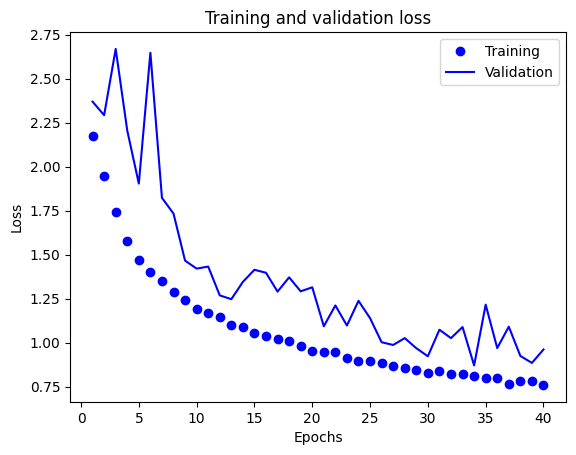

Ideal epoch for validation loss:  34 epochs
Validation loss:  0.8703754544258118


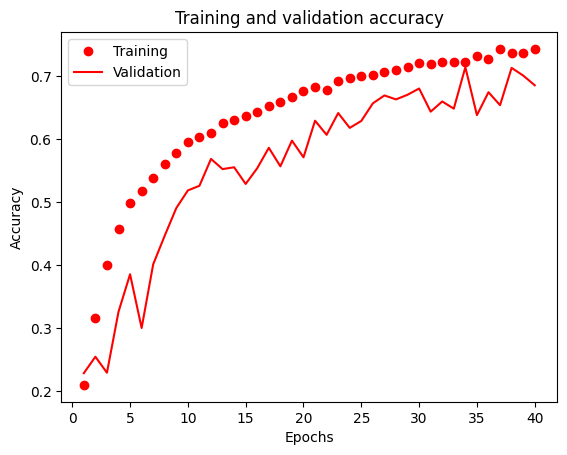

Ideal epoch for validation accuracy:  34 epochs
Validation accuracy:  0.7142331600189209
42/42 [==============================] - 9s 187ms/step
              precision    recall  f1-score   support

        cane       0.68      0.76      0.72       982
     cavallo       0.72      0.58      0.64       536
    elefante       0.60      0.78      0.68       300
    farfalla       0.49      0.94      0.64       416
     gallina       0.70      0.80      0.75       611
       gatto       0.67      0.45      0.54       361
       mucca       0.56      0.64      0.60       399
      pecora       0.68      0.61      0.64       433
       ragno       0.95      0.61      0.74       969
  scoiattolo       0.72      0.46      0.57       369

    accuracy                           0.67      5376
   macro avg       0.68      0.66      0.65      5376
weighted avg       0.71      0.67      0.67      5376



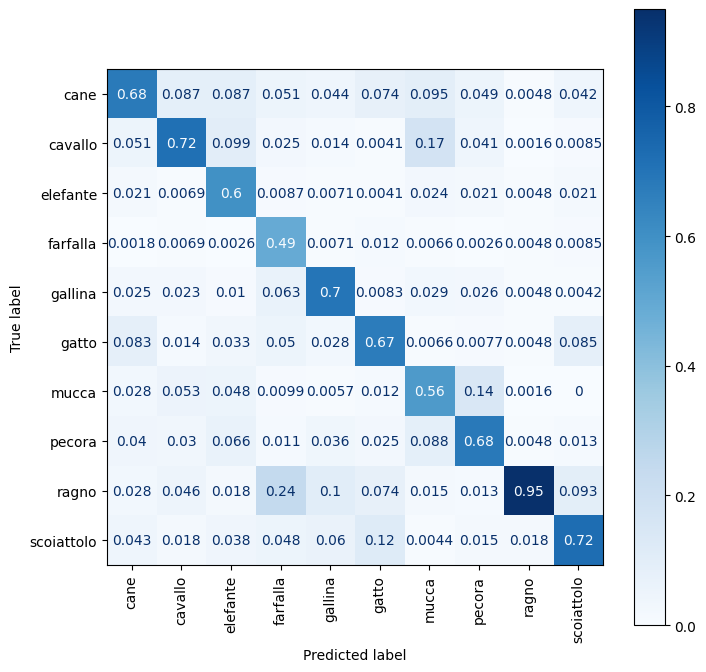

In [ ]:
evaluateModelsPerformance(cnn_model_aug_3, cnn_model_aug_3_history, processed_test_ds)

### CNN 5 Evaluation

F1 Score of 67. The best CNN performance when using data augmentation.
However, it is still worse than when not using data augmentation and it seems like the validation accuracy is quite unstable going up and down during the training.

I will conclude here the experimentation with CNN architecture, the best performing model was the one using Dropout and not using Data Augmentation.

## DNN vs CNN Performance

Here are the performances of the best DNN and CNN performing models compared


In [13]:
def plotClassPerformanceComparison(accuracies):
  class_names = ("cane", "cavallo", "elefante", "farfalla", "gallina", "gatto", "mucca", "pecora", "ragno", "scoiattolo")
  x = np.arange(len(class_names)) *  7  # the label locations

  width = 2  # the width of the bars
  multiplier = 0

  fig, ax = plt.subplots(layout='constrained', figsize=(17,5))

  for attribute, measurement in accuracies.items():
      offset = width * multiplier
      rects = ax.bar(x + offset, measurement, width, label=attribute)
      ax.bar_label(rects, padding=10, label_type="center")
      multiplier += 1

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Validation Accuracy')
  ax.set_title('Class accuracy by network architecture')
  ax.set_xticks(x + width, class_names)
  ax.legend(loc='upper left', ncols=3)
  ax.set_ylim(0, 100)

  plt.show()

def plotF1ScoreComparison(names, f1_scores):
  fig, ax = plt.subplots(figsize=(10,3))

  y_pos = np.arange(len(names))

  rects = ax.barh(y_pos, f1_scores, align='center', label=f1_scores, color=['tab:blue', 'tab:orange', 'tab:green'])
  ax.bar_label(rects, padding=10, label_type="center")
  ax.set_yticks(y_pos, labels=names)
  ax.invert_yaxis()  # labels read top-to-bottom
  ax.set_xlabel('Validation F1 Score')
  ax.set_title('Overall Performance by Network Architecture')
  ax.set_xlim(0, 100)


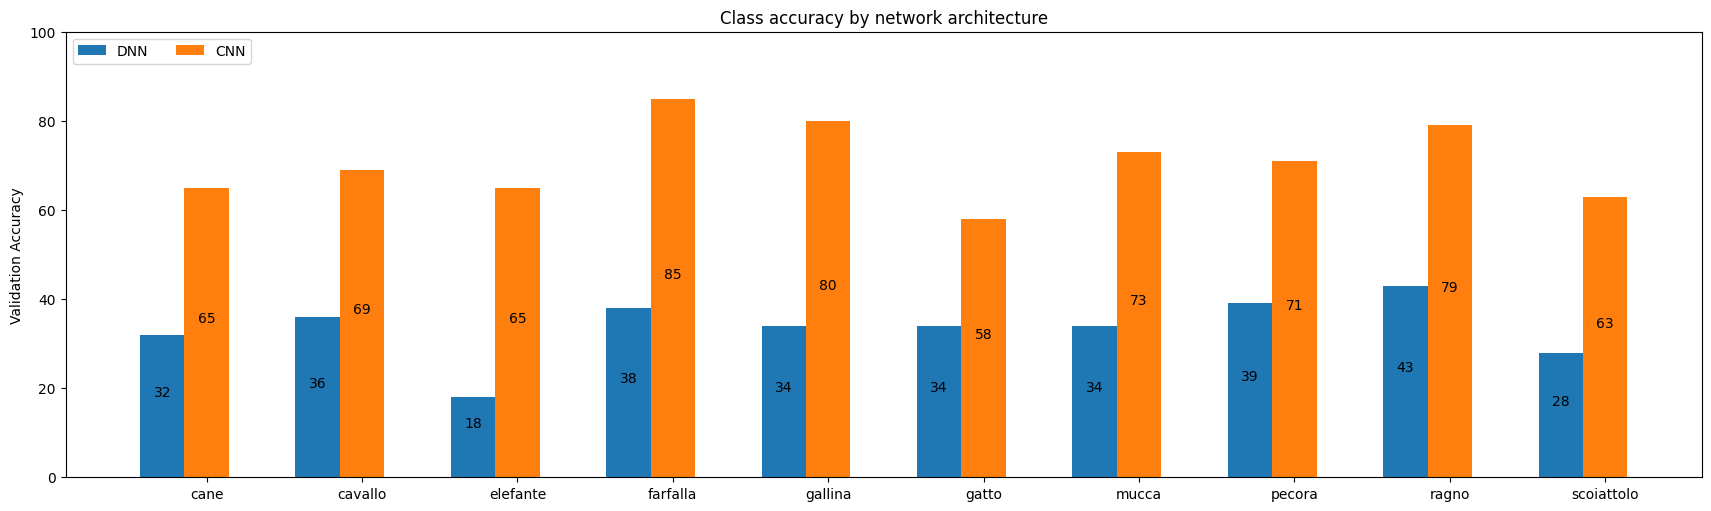

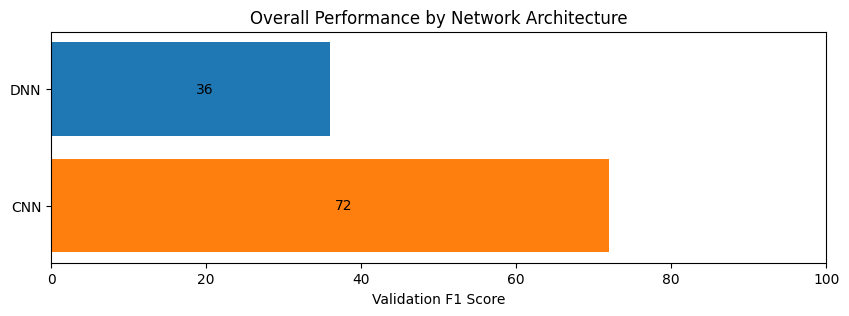

In [14]:
accuracies = {
    'DNN': (32, 36, 18, 38, 34, 34, 34, 39, 43, 28),
    'CNN': (65, 69, 65, 85, 80, 58, 73, 71, 79, 63)
}

plotClassPerformanceComparison(accuracies)

names = ('DNN', 'CNN')
f1_scores = [36, 72]

plotF1ScoreComparison(names, f1_scores)

## Inception Neural Network

We move on to explore an Inception Neural Network architecture. It is a kind of CNN network which performs multiple convolutions concurrently of different kernel sizes.

In [17]:
# This function creates an inception module and attaches it to the start layer passed in.
# It also takes the number of filters to use on each convolutional layer.
def inceptionModule(start_layer, filters_size = 32):

  branch_a = tf.keras.layers.Conv2D(filters_size, 1, activation='relu', strides=2)(start_layer)

  branch_b = tf.keras.layers.Conv2D(filters_size, 1, activation='relu')(start_layer)
  branch_b = tf.keras.layers.Conv2D(filters_size, 3, activation='relu', strides=2, padding="same")(branch_b)

  branch_c = tf.keras.layers.AveragePooling2D(2, strides=2, padding="same")(start_layer)
  branch_c = tf.keras.layers.Conv2D(filters_size, 3, activation='relu', padding="same")(branch_c)

  branch_d = tf.keras.layers.Conv2D(filters_size, 1, activation='relu')(start_layer)
  branch_d = tf.keras.layers.Conv2D(filters_size, 3, activation='relu', padding="same" )(branch_d)
  branch_d = tf.keras.layers.Conv2D(filters_size, 3, activation='relu', strides=2, padding="same")(branch_d)

  output = tf.keras.layers.concatenate([branch_a, branch_b, branch_c, branch_d], axis=-1)
  return output

## Inception Network 1

We start with an Inception Network using 2 Inception blocks to see how it compares to the CNN networks we did previously.

In [ ]:
#Build Inception Network
inputLayer = tf.keras.Input(shape=(150, 150, 3))
rescalingLayer = tf.keras.layers.Rescaling(1./255)(inputLayer)

inceptBlock1 = inceptionModule(rescalingLayer, 32)
inceptBlock2 = inceptionModule(inceptBlock1, 32)

avgPooling = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(inceptBlock2)
flat = tf.keras.layers.Flatten()(avgPooling)
dense = tf.keras.layers.Dense(128, activation="relu")(flat)
outputLayer = tf.keras.layers.Dense(num_classes, activation="softmax")(dense)

inceptionModel = tf.keras.Model(inputs=inputLayer, outputs=outputLayer)

### Visualise Network Summary and Plot Architecture

We visualise the network's architecture to validate that the inception blocks have been created successfuly and that the shape of the network matches our expectations which it does.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_9 (Rescaling)        (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 150, 150, 32  128         ['rescaling_9[0][0]']            
                                )                                                                 
                                                                                              

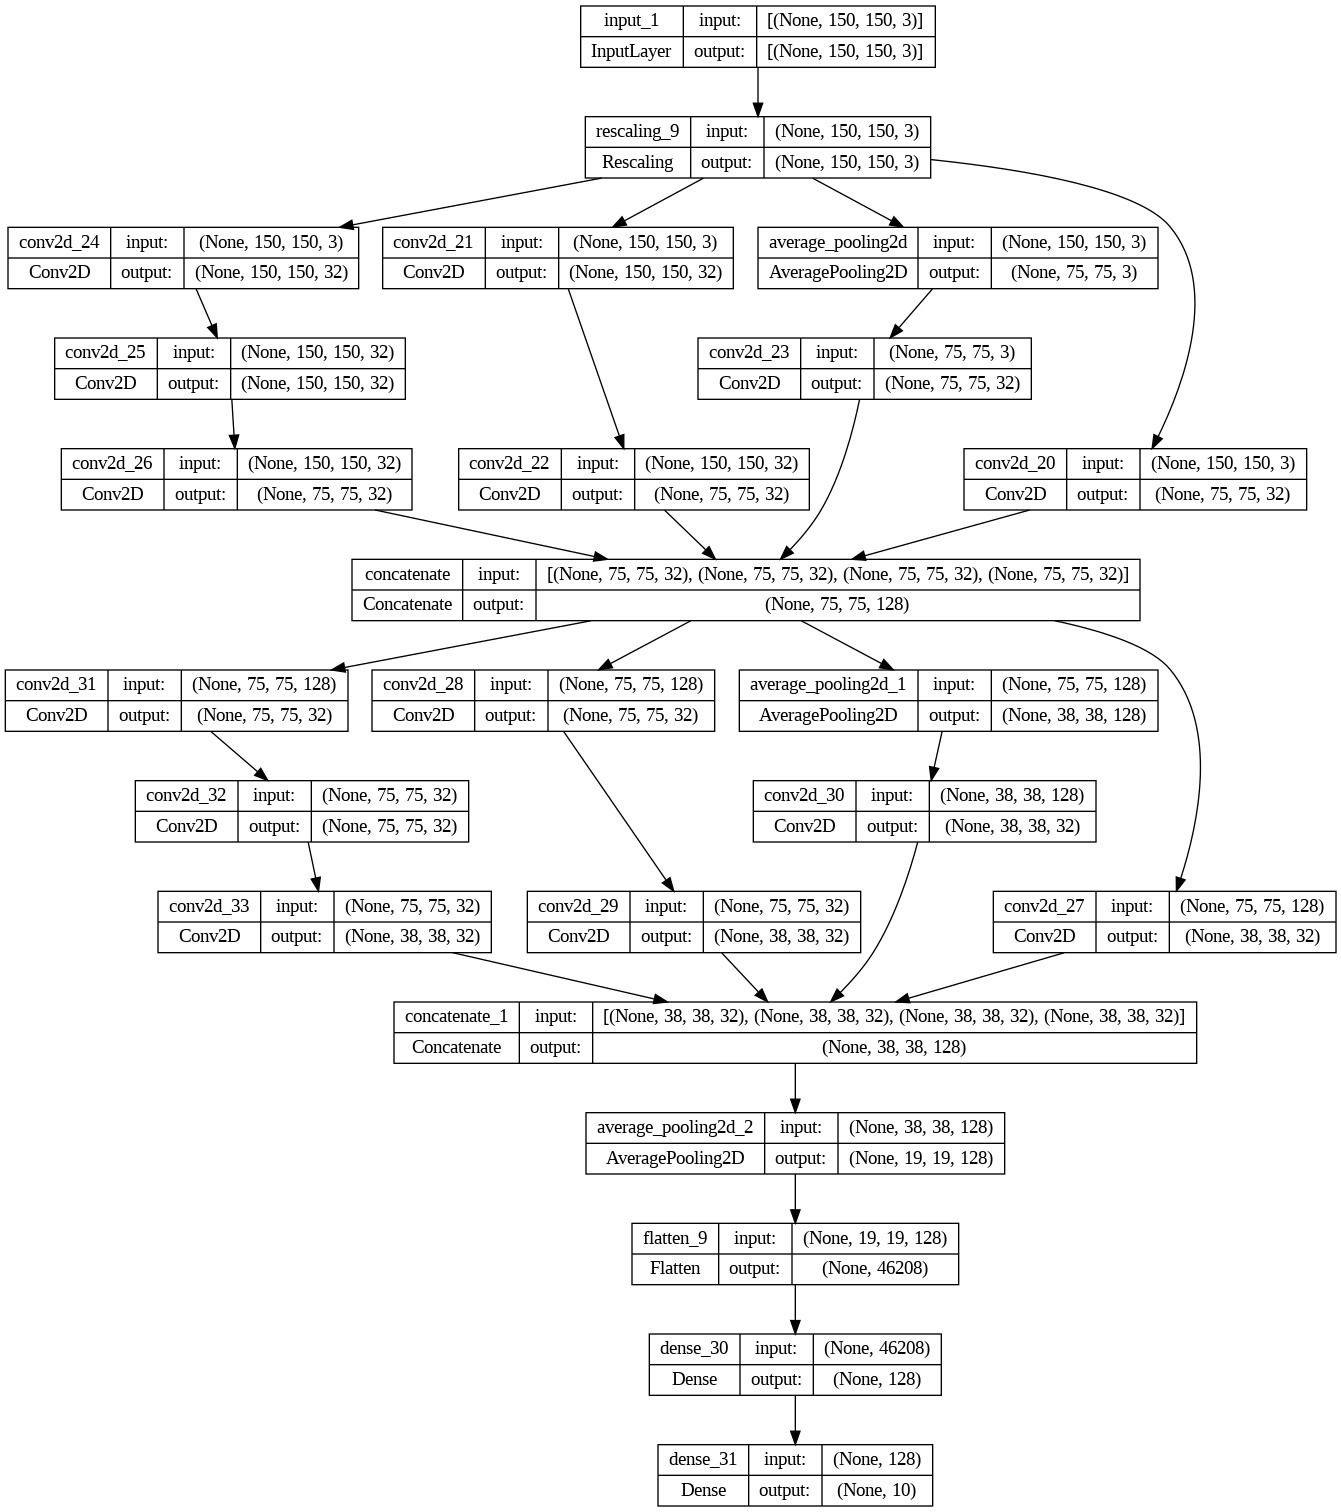

In [ ]:
inceptionModel.summary()

tf.keras.utils.plot_model(inceptionModel, show_shapes=True)

In [ ]:
inceptionModel.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

incept_history = inceptionModel.fit(
    processed_train_ds,
    validation_data=processed_val_ds,
    epochs=15
)

Epoch 1/15
148/148 [==============================] - 432s 3s/step - loss: 1.9743 - accuracy: 0.3104 - val_loss: 1.6189 - val_accuracy: 0.4377
Epoch 2/15
148/148 [==============================] - 421s 3s/step - loss: 1.5166 - accuracy: 0.4839 - val_loss: 1.4237 - val_accuracy: 0.5296
Epoch 3/15
148/148 [==============================] - 417s 3s/step - loss: 1.2913 - accuracy: 0.5694 - val_loss: 1.3206 - val_accuracy: 0.5726
Epoch 4/15
148/148 [==============================] - 416s 3s/step - loss: 1.0859 - accuracy: 0.6419 - val_loss: 1.2821 - val_accuracy: 0.5918
Epoch 5/15
148/148 [==============================] - 413s 3s/step - loss: 0.9015 - accuracy: 0.7026 - val_loss: 1.3686 - val_accuracy: 0.5954
Epoch 6/15
148/148 [==============================] - 415s 3s/step - loss: 0.7429 - accuracy: 0.7575 - val_loss: 1.4173 - val_accuracy: 0.5940
Epoch 7/15
148/148 [==============================] - 416s 3s/step - loss: 0.5967 - accuracy: 0.8047 - val_loss: 1.6525 - val_accuracy: 0.5873

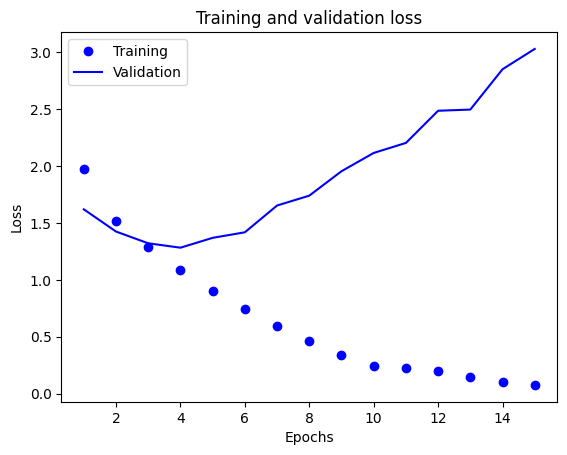

Ideal epoch for validation loss:  4 epochs
Validation loss:  1.2820521593093872


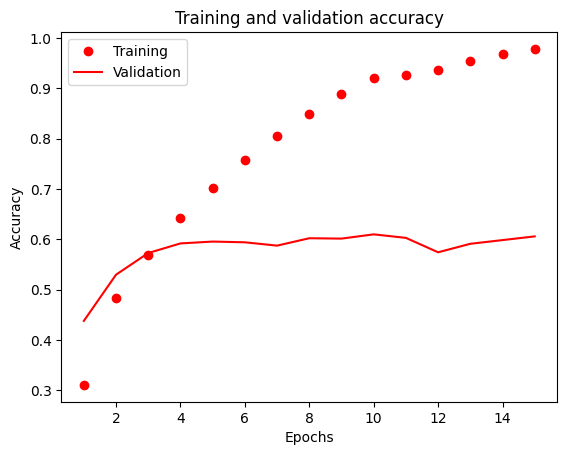

Ideal epoch for validation accuracy:  10 epochs
Validation accuracy:  0.6097829937934875
42/42 [==============================] - 17s 402ms/step
              precision    recall  f1-score   support

        cane       0.48      0.68      0.56       981
     cavallo       0.61      0.57      0.59       538
    elefante       0.52      0.51      0.52       290
    farfalla       0.60      0.72      0.65       410
     gallina       0.72      0.62      0.67       615
       gatto       0.47      0.28      0.35       359
       mucca       0.43      0.53      0.47       407
      pecora       0.66      0.48      0.56       444
       ragno       0.75      0.71      0.73       962
  scoiattolo       0.61      0.39      0.48       370

    accuracy                           0.59      5376
   macro avg       0.59      0.55      0.56      5376
weighted avg       0.60      0.59      0.58      5376



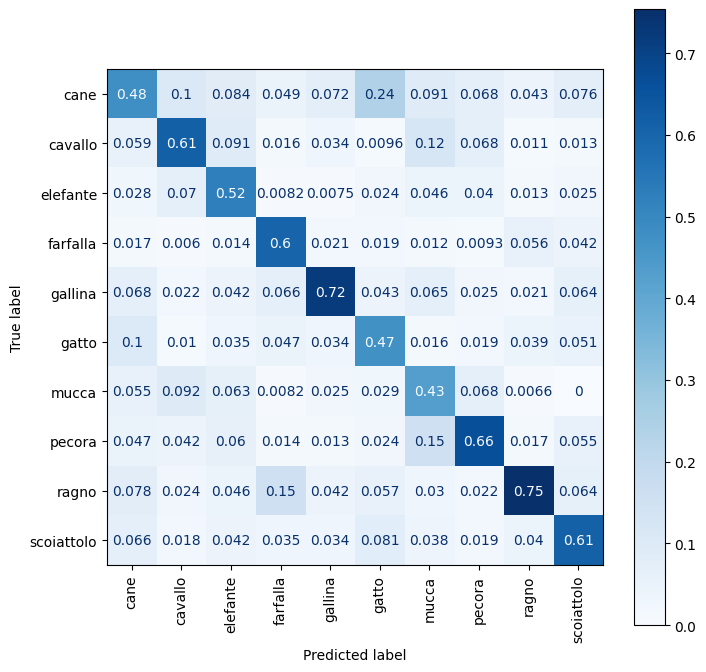

In [ ]:
evaluateModelsPerformance(inceptionModel, incept_history, processed_test_ds)

### Inception 1 Evaluation

The network archives fair results on the vaildation set. But what stands out is that is has learned the training set almost perfectly and the overfitting is huge. This tells me that this kind of network has massive capacity and the dataset we are working with isn't big enough to ripe the benfits.

I will try things to decrease overfitting and increase performance in the next iterations of the network.

## Inception Network 2: Dropout and More Average Pooling

Next I will add a big dropout layer after the inception modules and before the classifier to decrease the capacity of the network. I will also increase the ratio of the average pooling layer from 2,2 to 3,3 which also reduces capacity.

In [ ]:
#try to reduce overfitting in the inception network

inputLayer = tf.keras.Input(shape=(150, 150, 3))
rescalingLayer = tf.keras.layers.Rescaling(1./255)(inputLayer)

inceptBlock1 = inceptionModule(rescalingLayer, 32)
inceptBlock2 = inceptionModule(inceptBlock1, 32)

#ave pooling - factors by which to downscale - 3 times smaller
avgPooling = tf.keras.layers.AveragePooling2D(pool_size=(3, 3))(inceptBlock2)
flat = tf.keras.layers.Flatten()(avgPooling)
#dropout - fractionof the input units to drop
dropout = tf.keras.layers.Dropout(0.4)(flat)
dense = tf.keras.layers.Dense(128, activation="relu")(dropout)
outputLayer = tf.keras.layers.Dense(num_classes, activation="softmax")(dense)

inception_model_2 = tf.keras.Model(inputs=inputLayer, outputs=outputLayer)

inception_model_2.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

inception_model_2_history = inception_model_2.fit(
    processed_train_ds,
    validation_data=processed_val_ds,
    epochs=15
)


Epoch 1/15
148/148 [==============================] - 426s 3s/step - loss: 1.8974 - accuracy: 0.3254 - val_loss: 1.6284 - val_accuracy: 0.4351
Epoch 2/15
148/148 [==============================] - 424s 3s/step - loss: 1.4825 - accuracy: 0.4946 - val_loss: 1.3708 - val_accuracy: 0.5469
Epoch 3/15
148/148 [==============================] - 438s 3s/step - loss: 1.2681 - accuracy: 0.5735 - val_loss: 1.2533 - val_accuracy: 0.5774
Epoch 4/15
148/148 [==============================] - 433s 3s/step - loss: 1.1222 - accuracy: 0.6182 - val_loss: 1.2183 - val_accuracy: 0.5870
Epoch 5/15
148/148 [==============================] - 430s 3s/step - loss: 1.0141 - accuracy: 0.6575 - val_loss: 1.1446 - val_accuracy: 0.6193
Epoch 6/15
148/148 [==============================] - 422s 3s/step - loss: 0.9035 - accuracy: 0.6963 - val_loss: 1.1193 - val_accuracy: 0.6311
Epoch 7/15
148/148 [==============================] - 429s 3s/step - loss: 0.8134 - accuracy: 0.7269 - val_loss: 1.1247 - val_accuracy: 0.6399

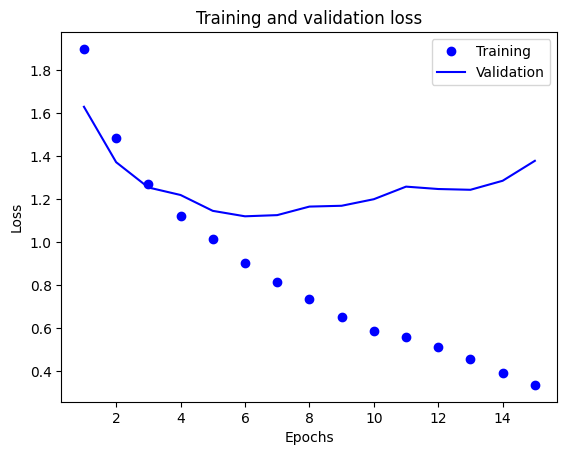

Ideal epoch for validation loss:  6 epochs
Validation loss:  1.119282841682434


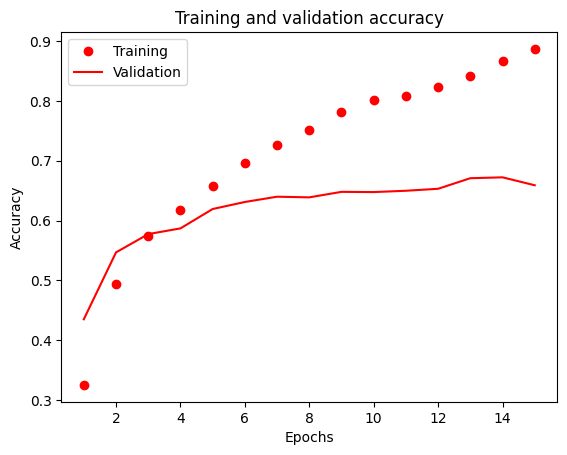

Ideal epoch for validation accuracy:  14 epochs
Validation accuracy:  0.6723060011863708
42/42 [==============================] - 18s 415ms/step
              precision    recall  f1-score   support

        cane       0.63      0.69      0.66       981
     cavallo       0.68      0.61      0.65       538
    elefante       0.51      0.62      0.56       290
    farfalla       0.66      0.77      0.71       410
     gallina       0.70      0.78      0.74       615
       gatto       0.54      0.37      0.44       359
       mucca       0.59      0.48      0.53       407
      pecora       0.68      0.63      0.65       444
       ragno       0.78      0.76      0.77       962
  scoiattolo       0.55      0.57      0.56       370

    accuracy                           0.66      5376
   macro avg       0.63      0.63      0.63      5376
weighted avg       0.66      0.66      0.65      5376



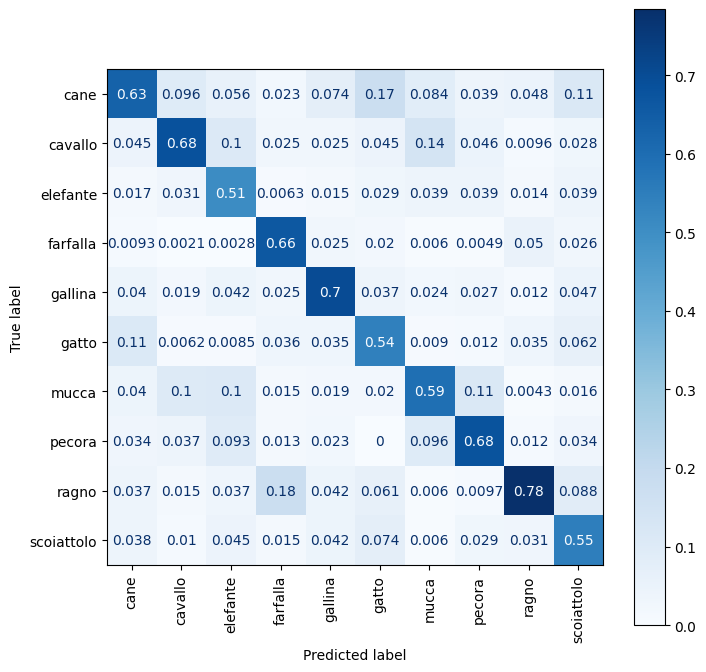

In [ ]:
evaluateModelsPerformance(inception_model_2, inception_model_2_history, processed_test_ds)

Ideas to improve overfitting:

1.   Data Augmentation
2.   Reduce number of filters in the inception convolutions



### Inception 2 Evaluation

This has helped with overfitting and the performance of the network. Val accuracy has gone up to 0.65. However overfitting is still present and this is still not as good as the best CNN network.

I will try reducing the capacity even further.

## Inception Network 3: Further reduce overfitting

Reduce convolutional filters from 32 to 20 per layer.
Add extra dropout of 0.1 before final softmax layer

In [ ]:
inputLayer = tf.keras.Input(shape=(150, 150, 3))
rescalingLayer = tf.keras.layers.Rescaling(1./255)(inputLayer)

inceptBlock1 = inceptionModule(rescalingLayer, 20)
inceptBlock2 = inceptionModule(inceptBlock1, 20)

#ave pooling - factors by which to downscale - 3 times smaller
avgPooling = tf.keras.layers.AveragePooling2D(pool_size=(3, 3))(inceptBlock2)
flat = tf.keras.layers.Flatten()(avgPooling)
#dropout - fractionof the input units to drop
dropout = tf.keras.layers.Dropout(0.4)(flat)
dense = tf.keras.layers.Dense(128, activation="relu")(dropout)
dropout2 = tf.keras.layers.Dropout(0.1)(dense)
outputLayer = tf.keras.layers.Dense(num_classes, activation="softmax")(dropout2)

inception_model_3 = tf.keras.Model(inputs=inputLayer, outputs=outputLayer)

inception_model_3.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

inception_model_3_history = inception_model_3.fit(
    processed_train_ds,
    validation_data=processed_val_ds,
    epochs=20
)

Epoch 1/20
148/148 [==============================] - 328s 2s/step - loss: 2.0122 - accuracy: 0.2839 - val_loss: 1.7053 - val_accuracy: 0.4060
Epoch 2/20
148/148 [==============================] - 253s 2s/step - loss: 1.6314 - accuracy: 0.4352 - val_loss: 1.5422 - val_accuracy: 0.4682
Epoch 3/20
148/148 [==============================] - 253s 2s/step - loss: 1.4455 - accuracy: 0.5070 - val_loss: 1.3793 - val_accuracy: 0.5392
Epoch 4/20
148/148 [==============================] - 253s 2s/step - loss: 1.3332 - accuracy: 0.5488 - val_loss: 1.2972 - val_accuracy: 0.5767
Epoch 5/20
148/148 [==============================] - 254s 2s/step - loss: 1.2332 - accuracy: 0.5843 - val_loss: 1.2565 - val_accuracy: 0.5862
Epoch 6/20
148/148 [==============================] - 254s 2s/step - loss: 1.1640 - accuracy: 0.6044 - val_loss: 1.2560 - val_accuracy: 0.5859
Epoch 7/20
148/148 [==============================] - 254s 2s/step - loss: 1.1075 - accuracy: 0.6231 - val_loss: 1.2143 - val_accuracy: 0.6013

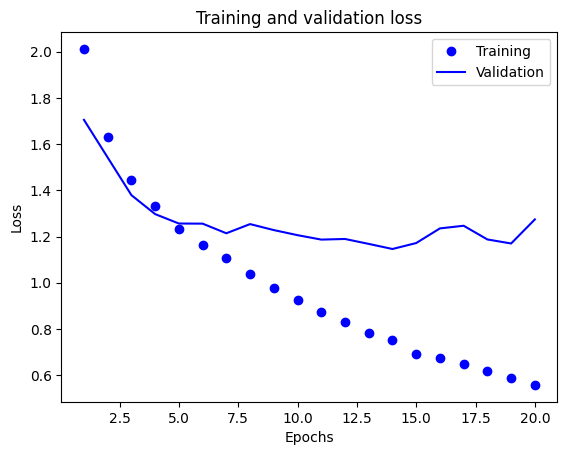

Ideal epoch for validation loss:  14 epochs
Validation loss:  1.146233320236206


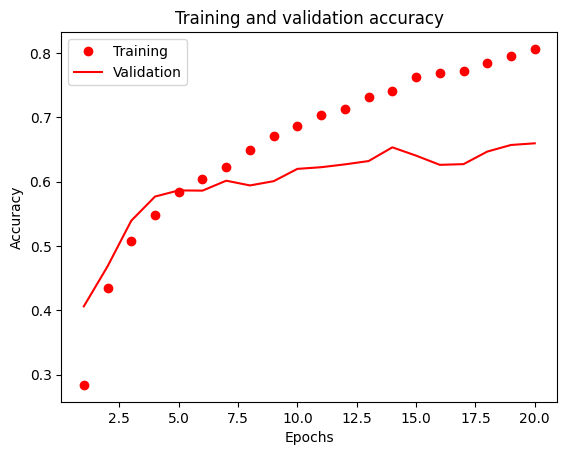

Ideal epoch for validation accuracy:  20 epochs
Validation accuracy:  0.6594336032867432
42/42 [==============================] - 11s 254ms/step
              precision    recall  f1-score   support

        cane       0.58      0.70      0.63       982
     cavallo       0.65      0.62      0.64       536
    elefante       0.59      0.52      0.55       300
    farfalla       0.69      0.83      0.75       416
     gallina       0.74      0.70      0.72       611
       gatto       0.70      0.23      0.35       361
       mucca       0.52      0.54      0.53       399
      pecora       0.65      0.57      0.61       433
       ragno       0.75      0.80      0.78       969
  scoiattolo       0.53      0.56      0.54       369

    accuracy                           0.65      5376
   macro avg       0.64      0.61      0.61      5376
weighted avg       0.65      0.65      0.64      5376



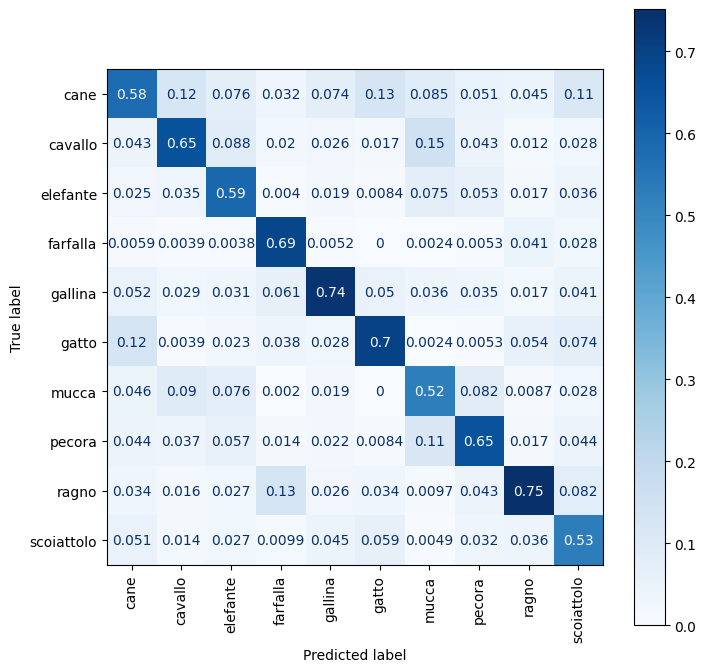

In [ ]:
evaluateModelsPerformance(inception_model_3, inception_model_3_history, processed_test_ds)

### Inception 3 Evaluation

Performance remained the same, network is a bit too powerful still and overfitting is happening.

## Inception Network 4: Use data augmentation

It is clear that the network is learning the trainig set too closely despite the regularisation techniques. I will use data augmenation to ensure the network does not see the same image twice, thus greatly reducing the chance of it learning the training set completely.

In [ ]:
inputLayer = tf.keras.Input(shape=(150, 150, 3))
rescalingLayer = tf.keras.layers.Rescaling(1./255)(inputLayer)

inceptBlock1 = inceptionModule(rescalingLayer, 10)
inceptBlock2 = inceptionModule(inceptBlock1, 10)

#ave pooling - factors by which to downscale - 3 times smaller
avgPooling = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(inceptBlock2)
flat = tf.keras.layers.Flatten()(avgPooling)
#dropout - fractionof the input units to drop
dropout = tf.keras.layers.Dropout(0.3)(flat)
dense = tf.keras.layers.Dense(128, activation="relu")(dropout)
outputLayer = tf.keras.layers.Dense(num_classes, activation="softmax")(dense)

inception_model_aug_1 = tf.keras.Model(inputs=inputLayer, outputs=outputLayer)

inception_model_aug_1.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

inception_model_aug_1_history = inception_model_aug_1.fit(
    processed_augmented_train_ds,
    validation_data=processed_val_ds,
    epochs=15
)

Epoch 1/15
148/148 [==============================] - 110s 715ms/step - loss: 2.1497 - accuracy: 0.2218 - val_loss: 1.9311 - val_accuracy: 0.3082
Epoch 2/15
148/148 [==============================] - 107s 714ms/step - loss: 1.9443 - accuracy: 0.3105 - val_loss: 1.7663 - val_accuracy: 0.3917
Epoch 3/15
148/148 [==============================] - 106s 708ms/step - loss: 1.8360 - accuracy: 0.3577 - val_loss: 1.7092 - val_accuracy: 0.4097
Epoch 4/15
148/148 [==============================] - 107s 712ms/step - loss: 1.7643 - accuracy: 0.3910 - val_loss: 1.6180 - val_accuracy: 0.4583
Epoch 5/15
148/148 [==============================] - 107s 710ms/step - loss: 1.7044 - accuracy: 0.4133 - val_loss: 1.5743 - val_accuracy: 0.4675
Epoch 6/15
148/148 [==============================] - 107s 713ms/step - loss: 1.6495 - accuracy: 0.4368 - val_loss: 1.4901 - val_accuracy: 0.5024
Epoch 7/15
148/148 [==============================] - 107s 717ms/step - loss: 1.6183 - accuracy: 0.4463 - val_loss: 1.5004 -

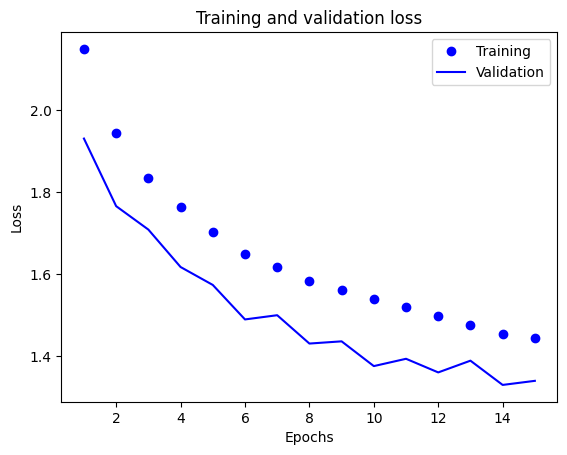

Ideal epoch for validation loss:  14 epochs
Validation loss:  1.3304665088653564


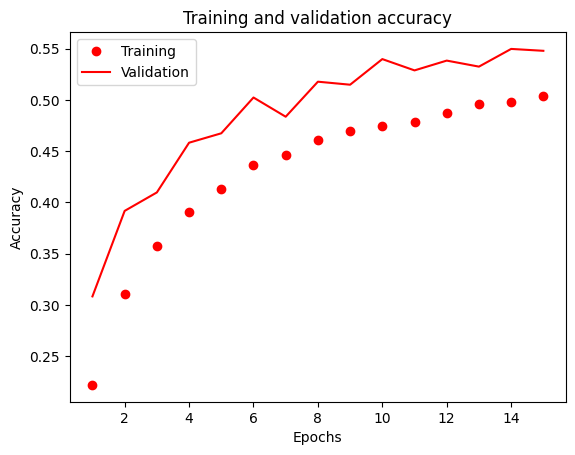

Ideal epoch for validation accuracy:  14 epochs
Validation accuracy:  0.5498344898223877
42/42 [==============================] - 6s 132ms/step
              precision    recall  f1-score   support

        cane       0.54      0.59      0.56       981
     cavallo       0.42      0.62      0.50       538
    elefante       0.53      0.34      0.41       290
    farfalla       0.49      0.81      0.61       410
     gallina       0.55      0.77      0.64       615
       gatto       0.56      0.08      0.14       359
       mucca       0.40      0.30      0.35       407
      pecora       0.55      0.44      0.49       444
       ragno       0.73      0.68      0.70       962
  scoiattolo       0.57      0.28      0.38       370

    accuracy                           0.54      5376
   macro avg       0.53      0.49      0.48      5376
weighted avg       0.55      0.54      0.52      5376



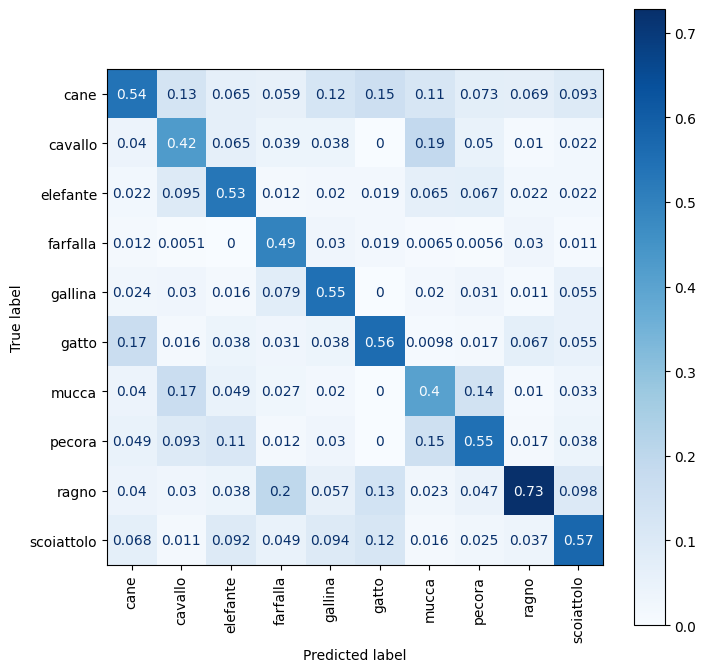

In [ ]:
evaluateModelsPerformance(inception_model_aug_1, inception_model_aug_1_history, processed_test_ds)

### Inception 4 Evaluation

Now overfitting is no longer happening but the network is not learning enough.
I will try increasing the capacity of the network by doing:

- Using 12 filters for convolutional layers
- Increasing the amount of inception blocks to 3
- Increased the classifier to be a dense 512 unit layer
- Remove dropout layer. Data augmentation seems to regularise enough

## Inception Network 5

In [ ]:
inputLayer = tf.keras.Input(shape=(150, 150, 3))
rescalingLayer = tf.keras.layers.Rescaling(1./255)(inputLayer)

inceptBlock1 = inceptionModule(rescalingLayer, 12)
inceptBlock2 = inceptionModule(inceptBlock1, 12)
inceptBlock3 = inceptionModule(inceptBlock2, 12)

#ave pooling - factors by which to downscale - 3 times smaller
avgPooling = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(inceptBlock3)
flat = tf.keras.layers.Flatten()(avgPooling)
dense = tf.keras.layers.Dense(512, activation="relu")(flat)
outputLayer = tf.keras.layers.Dense(num_classes, activation="softmax")(dense)

inception_model_aug_2 = tf.keras.Model(inputs=inputLayer, outputs=outputLayer)

inception_model_aug_2.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

inception_model_aug_2_history = inception_model_aug_2.fit(
    processed_augmented_train_ds,
    validation_data=processed_val_ds,
    epochs=20
)

Epoch 1/20
148/148 [==============================] - 238s 2s/step - loss: 2.0334 - accuracy: 0.2713 - val_loss: 1.8235 - val_accuracy: 0.3648
Epoch 2/20
148/148 [==============================] - 170s 1s/step - loss: 1.8247 - accuracy: 0.3635 - val_loss: 1.6832 - val_accuracy: 0.4329
Epoch 3/20
148/148 [==============================] - 171s 1s/step - loss: 1.7176 - accuracy: 0.4070 - val_loss: 1.7433 - val_accuracy: 0.4119
Epoch 4/20
148/148 [==============================] - 210s 1s/step - loss: 1.6348 - accuracy: 0.4420 - val_loss: 1.5700 - val_accuracy: 0.4803
Epoch 5/20
148/148 [==============================] - 206s 1s/step - loss: 1.5655 - accuracy: 0.4631 - val_loss: 1.4737 - val_accuracy: 0.5057
Epoch 6/20
148/148 [==============================] - 198s 1s/step - loss: 1.4927 - accuracy: 0.4942 - val_loss: 1.4479 - val_accuracy: 0.5215
Epoch 7/20
148/148 [==============================] - 182s 1s/step - loss: 1.4545 - accuracy: 0.5032 - val_loss: 1.4238 - val_accuracy: 0.5278

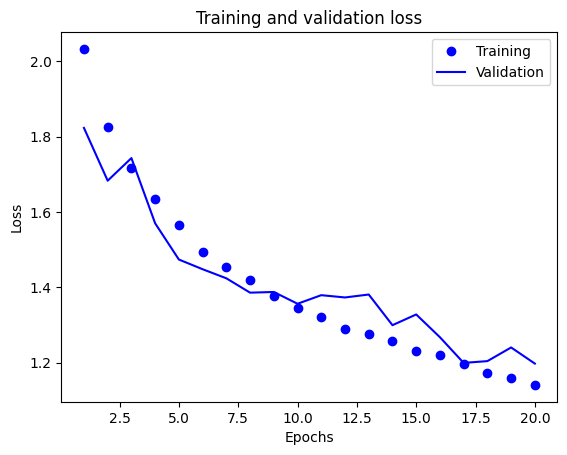

Ideal epoch for validation loss:  20 epochs
Validation loss:  1.197157382965088


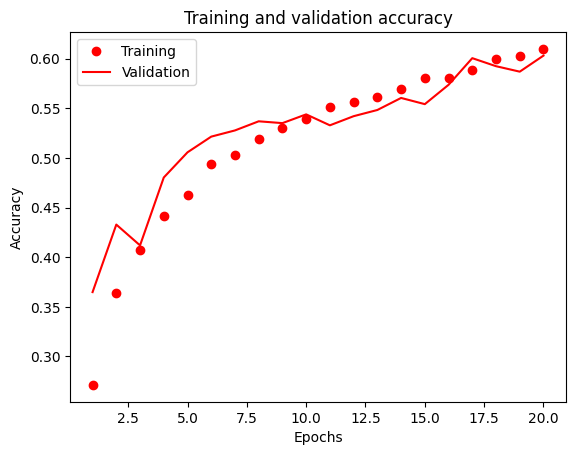

Ideal epoch for validation accuracy:  20 epochs
Validation accuracy:  0.603162944316864
42/42 [==============================] - 8s 166ms/step
              precision    recall  f1-score   support

        cane       0.60      0.67      0.63       982
     cavallo       0.71      0.48      0.58       536
    elefante       0.70      0.44      0.54       300
    farfalla       0.47      0.90      0.62       416
     gallina       0.75      0.79      0.77       611
       gatto       0.61      0.12      0.20       361
       mucca       0.40      0.64      0.49       399
      pecora       0.60      0.49      0.54       433
       ragno       0.77      0.74      0.75       969
  scoiattolo       0.60      0.49      0.54       369

    accuracy                           0.62      5376
   macro avg       0.62      0.57      0.57      5376
weighted avg       0.64      0.62      0.60      5376



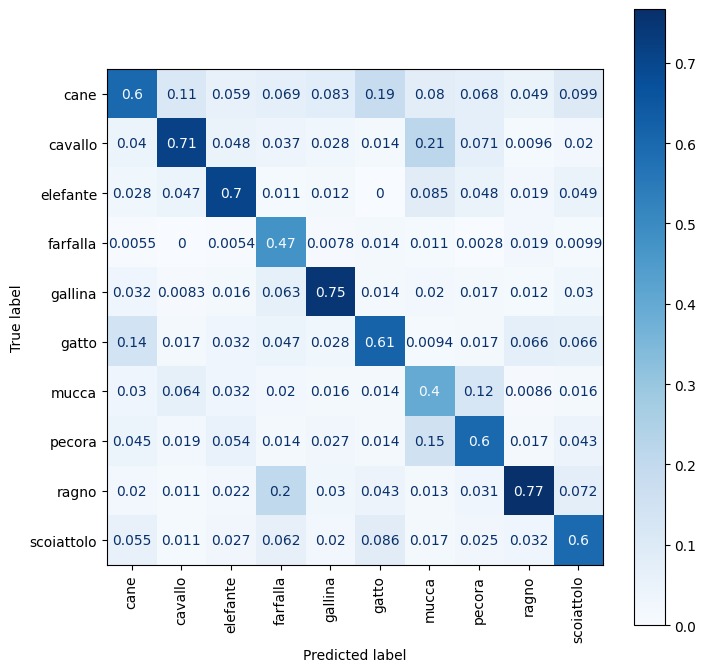

In [ ]:
evaluateModelsPerformance(inception_model_aug_2, inception_model_aug_2_history, processed_test_ds)

### Inception 5 Evaluation

The model seems quite good now, although it is not yet reaching 70% accuracy as with CNN.

I do not see any overfitting yet so I will try to increase capacity as follows:

- Add extra inception block (4)
- Increase Adam's optimiser's learning rate to 0.005 (to hopefully make it learn faster)
- Make the classifier be 2 layers instead of one.

## Inception Network 6

In [ ]:
inputLayer = tf.keras.Input(shape=(150, 150, 3))
rescalingLayer = tf.keras.layers.Rescaling(1./255)(inputLayer)

inceptBlock1 = inceptionModule(rescalingLayer, 12)
inceptBlock2 = inceptionModule(inceptBlock1, 12)
inceptBlock3 = inceptionModule(inceptBlock2, 12)
inceptBlock4 = inceptionModule(inceptBlock3, 12)

#ave pooling - factors by which to downscale - 2 times smaller
avgPooling = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(inceptBlock4)
flat = tf.keras.layers.Flatten()(avgPooling)
#classifier dense layers
dense = tf.keras.layers.Dense(256, activation="relu")(flat)
dense2 = tf.keras.layers.Dense(256, activation="relu")(dense)
outputLayer = tf.keras.layers.Dense(num_classes, activation="softmax")(dense2)

inception_model_aug_3 = tf.keras.Model(inputs=inputLayer, outputs=outputLayer)

inception_model_aug_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss="categorical_crossentropy",
    metrics=["accuracy"])

inception_model_aug_3_history = inception_model_aug_3.fit(
    processed_augmented_train_ds,
    validation_data=processed_val_ds,
    epochs=20
)

Epoch 1/20
148/148 [==============================] - 175s 1s/step - loss: 2.1453 - accuracy: 0.2097 - val_loss: 1.9997 - val_accuracy: 0.2677
Epoch 2/20
148/148 [==============================] - 170s 1s/step - loss: 1.9643 - accuracy: 0.2989 - val_loss: 1.7884 - val_accuracy: 0.3781
Epoch 3/20
148/148 [==============================] - 170s 1s/step - loss: 1.8135 - accuracy: 0.3649 - val_loss: 1.7438 - val_accuracy: 0.3932
Epoch 4/20
148/148 [==============================] - 171s 1s/step - loss: 1.7499 - accuracy: 0.3908 - val_loss: 1.7371 - val_accuracy: 0.4145
Epoch 5/20
148/148 [==============================] - 171s 1s/step - loss: 1.6965 - accuracy: 0.4114 - val_loss: 1.6325 - val_accuracy: 0.4454
Epoch 6/20
148/148 [==============================] - 170s 1s/step - loss: 1.6660 - accuracy: 0.4248 - val_loss: 1.5904 - val_accuracy: 0.4586
Epoch 7/20
148/148 [==============================] - 170s 1s/step - loss: 1.6386 - accuracy: 0.4321 - val_loss: 1.6092 - val_accuracy: 0.4428

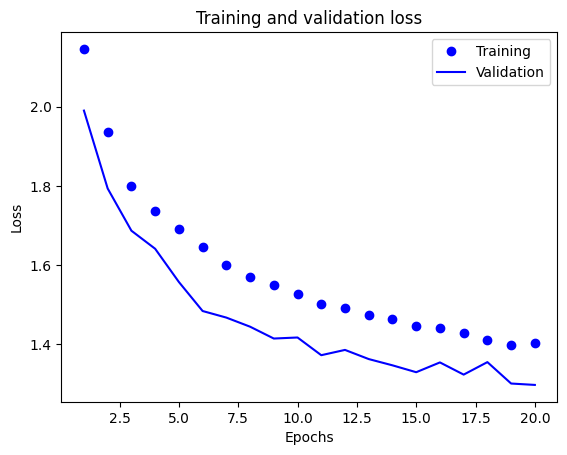

Ideal epoch for validation loss:  20 epochs
Validation loss:  1.2972484827041626


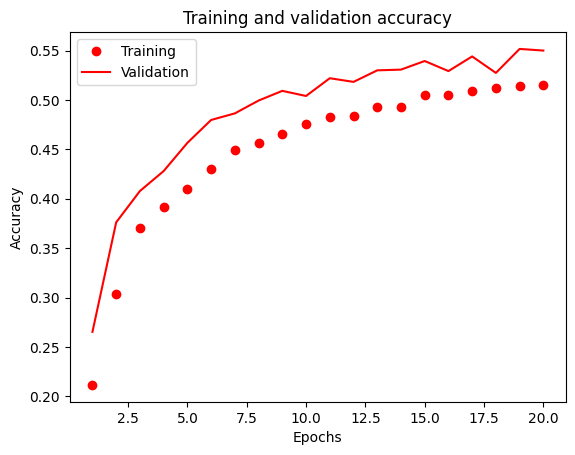

Ideal epoch for validation accuracy:  19 epochs
Validation accuracy:  0.5516027212142944
43/43 [==============================] - 7s 156ms/step


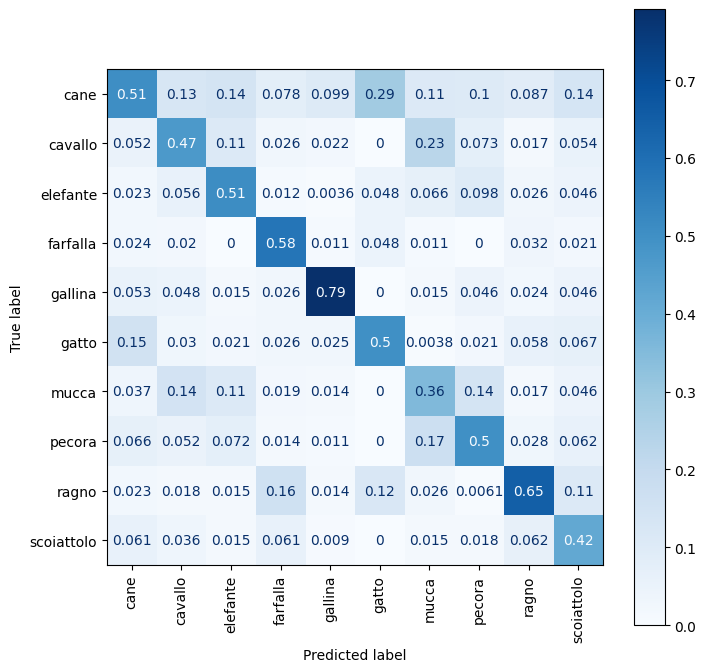

In [ ]:
evaluateModelsPerformance(inception_model_aug_3, inception_model_aug_3_history, processed_test_ds)

### Inception 6 Evaluation

Increasing the learning rate was a mistake and greatly reduced the performance of the network. I will revert that in the next model.

The network before last was no longer overfitting but it was not learning the trainig set well enough. This is understandable because data augmentation is being used.

My hypothesis now is that I can increase the size of the network considerably since overfitting is unlikely. I will test this in the next network.

## Inception Network 7

I will increase capacity as follows:

- Increase to 4 inception modules with 30 filters each.
- Increase the classifier greatly by having 4 layers of 1024 units each.
- I will add slight dropout layers in the classifier to control overfitting since I have increase it so much in size.





In [ ]:
inputLayer = tf.keras.Input(shape=(150, 150, 3))
rescalingLayer = tf.keras.layers.Rescaling(1./255)(inputLayer)

inceptBlock1 = inceptionModule(rescalingLayer, 30)
inceptBlock2 = inceptionModule(inceptBlock1, 30)
inceptBlock3 = inceptionModule(inceptBlock2, 30)
inceptBlock4 = inceptionModule(inceptBlock3, 30)

#ave pooling - factors by which to downscale - 2 times smaller
avgPooling = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(inceptBlock4)
flat = tf.keras.layers.Flatten()(avgPooling)
#classifier dense layers
dense = tf.keras.layers.Dense(1024, activation="relu")(flat)
dp1 = tf.keras.layers.Dropout(0.2)(dense)
dense2 = tf.keras.layers.Dense(1024, activation="relu")(dp1)
dp2 = tf.keras.layers.Dropout(0.2)(dense2)
dense3 = tf.keras.layers.Dense(1024, activation="relu")(dp2)
dp3 = tf.keras.layers.Dropout(0.2)(dense3)
dense4 = tf.keras.layers.Dense(1024, activation="relu")(dp3)
outputLayer = tf.keras.layers.Dense(num_classes, activation="softmax")(dense4)

inception_model_aug_4 = tf.keras.Model(inputs=inputLayer, outputs=outputLayer)

inception_model_aug_4.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

inception_model_aug_4_history = inception_model_aug_4.fit(
    processed_augmented_train_ds,
    validation_data=processed_val_ds,
    epochs=30
)

Epoch 1/30
148/148 [==============================] - 423s 3s/step - loss: 2.1579 - accuracy: 0.2026 - val_loss: 1.9949 - val_accuracy: 0.2574
Epoch 2/30
148/148 [==============================] - 416s 3s/step - loss: 1.9800 - accuracy: 0.2826 - val_loss: 1.8314 - val_accuracy: 0.3615
Epoch 3/30
148/148 [==============================] - 416s 3s/step - loss: 1.8244 - accuracy: 0.3668 - val_loss: 1.7568 - val_accuracy: 0.3946
Epoch 4/30
148/148 [==============================] - 415s 3s/step - loss: 1.7292 - accuracy: 0.4029 - val_loss: 1.5928 - val_accuracy: 0.4542
Epoch 5/30
148/148 [==============================] - 416s 3s/step - loss: 1.6481 - accuracy: 0.4314 - val_loss: 1.6065 - val_accuracy: 0.4564
Epoch 6/30
148/148 [==============================] - 416s 3s/step - loss: 1.5773 - accuracy: 0.4617 - val_loss: 1.5777 - val_accuracy: 0.4678
Epoch 7/30
148/148 [==============================] - 416s 3s/step - loss: 1.5293 - accuracy: 0.4768 - val_loss: 1.4292 - val_accuracy: 0.5193

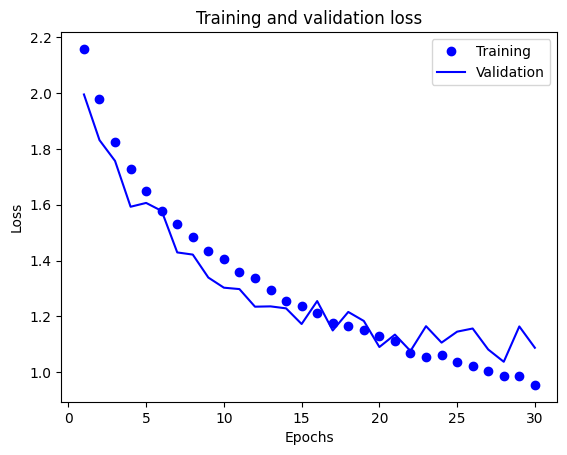

Ideal epoch for validation loss:  28 epochs
Validation loss:  1.0375845432281494


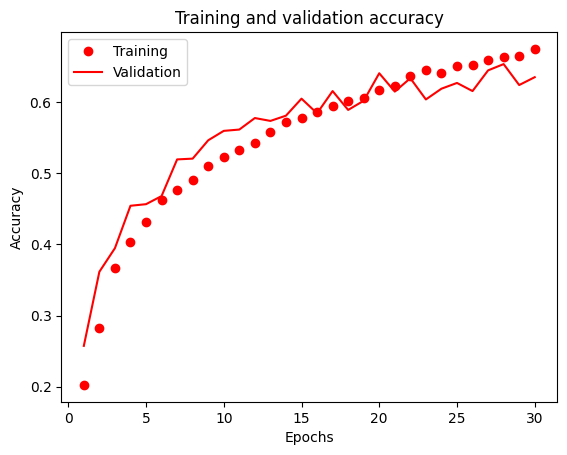

Ideal epoch for validation accuracy:  28 epochs
Validation accuracy:  0.6531813144683838
42/42 [==============================] - 18s 429ms/step
              precision    recall  f1-score   support

        cane       0.74      0.59      0.66       982
     cavallo       0.65      0.48      0.55       536
    elefante       0.53      0.66      0.59       300
    farfalla       0.59      0.89      0.71       416
     gallina       0.65      0.88      0.75       611
       gatto       0.68      0.31      0.43       361
       mucca       0.42      0.55      0.48       399
      pecora       0.57      0.62      0.59       433
       ragno       0.85      0.71      0.77       969
  scoiattolo       0.56      0.62      0.59       369

    accuracy                           0.64      5376
   macro avg       0.62      0.63      0.61      5376
weighted avg       0.66      0.64      0.64      5376



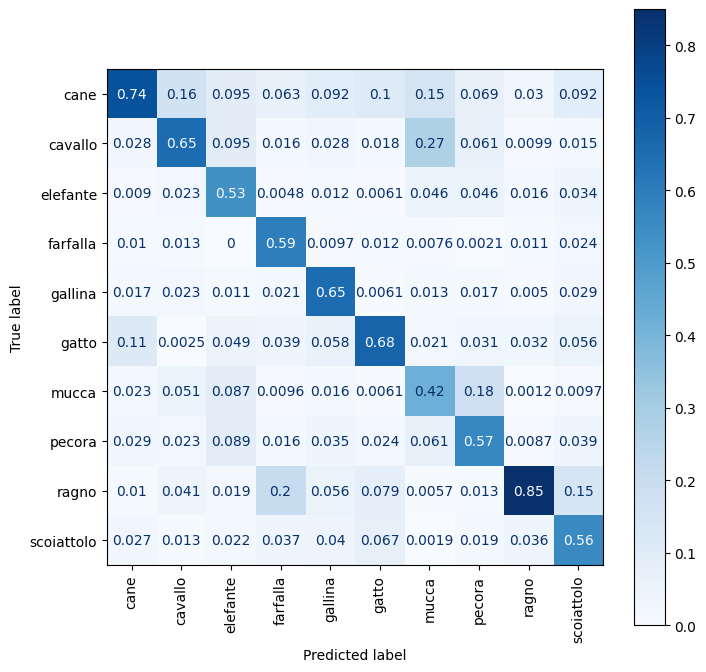

In [ ]:
evaluateModelsPerformance(inception_model_aug_4, inception_model_aug_4_history, processed_test_ds)

### Inception 7 Evaluation

Ok performance hasn't increased dramatically but looking at the graphs, I think we are in the right patch. The network is learning well.

I will train for longer as I can see the graph was still increasing without overfitting when training stopped.

## Inception network 8

Keep everything the same but train for longer (40 epochs)

In [ ]:
inputLayer = tf.keras.Input(shape=(150, 150, 3))
rescalingLayer = tf.keras.layers.Rescaling(1./255)(inputLayer)

inceptBlock1 = inceptionModule(rescalingLayer, 30)
inceptBlock2 = inceptionModule(inceptBlock1, 30)
inceptBlock3 = inceptionModule(inceptBlock2, 30)
inceptBlock4 = inceptionModule(inceptBlock3, 30)

#ave pooling - factors by which to downscale - 2 times smaller
avgPooling = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(inceptBlock4)
flat = tf.keras.layers.Flatten()(avgPooling)
#classifier dense layers
dense = tf.keras.layers.Dense(1024, activation="relu")(flat)
dp1 = tf.keras.layers.Dropout(0.2)(dense)
dense2 = tf.keras.layers.Dense(1024, activation="relu")(dp1)
dp2 = tf.keras.layers.Dropout(0.2)(dense2)
dense3 = tf.keras.layers.Dense(1024, activation="relu")(dp2)
dp3 = tf.keras.layers.Dropout(0.2)(dense3)
dense4 = tf.keras.layers.Dense(1024, activation="relu")(dp3)
outputLayer = tf.keras.layers.Dense(num_classes, activation="softmax")(dense4)

inception_model_aug_5 = tf.keras.Model(inputs=inputLayer, outputs=outputLayer)

inception_model_aug_5.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

inception_model_aug_5_history = inception_model_aug_5.fit(
    processed_augmented_train_ds,
    validation_data=processed_val_ds,
    epochs=40
)

Epoch 1/40
148/148 [==============================] - 430s 3s/step - loss: 2.1719 - accuracy: 0.1974 - val_loss: 2.0371 - val_accuracy: 0.2464
Epoch 2/40
148/148 [==============================] - 422s 3s/step - loss: 1.9987 - accuracy: 0.2728 - val_loss: 1.8138 - val_accuracy: 0.3652
Epoch 3/40
148/148 [==============================] - 425s 3s/step - loss: 1.8300 - accuracy: 0.3612 - val_loss: 1.7110 - val_accuracy: 0.4042
Epoch 4/40
148/148 [==============================] - 422s 3s/step - loss: 1.7449 - accuracy: 0.3933 - val_loss: 1.6608 - val_accuracy: 0.4244
Epoch 5/40
148/148 [==============================] - 422s 3s/step - loss: 1.6668 - accuracy: 0.4268 - val_loss: 1.5790 - val_accuracy: 0.4583
Epoch 6/40
148/148 [==============================] - 420s 3s/step - loss: 1.6089 - accuracy: 0.4498 - val_loss: 1.4400 - val_accuracy: 0.5035
Epoch 7/40
148/148 [==============================] - 427s 3s/step - loss: 1.5565 - accuracy: 0.4709 - val_loss: 1.4307 - val_accuracy: 0.5083

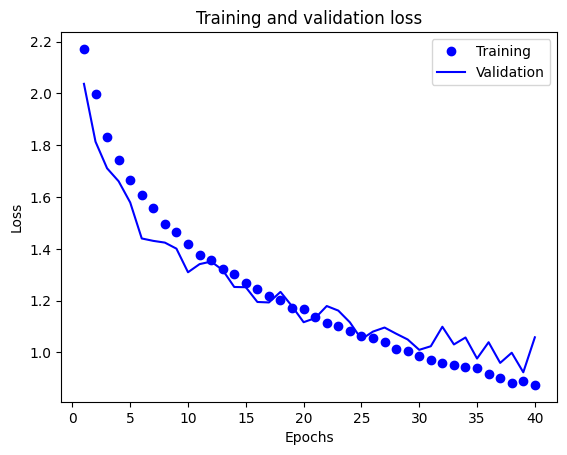

Ideal epoch for validation loss:  39 epochs
Validation loss:  0.9233054518699646


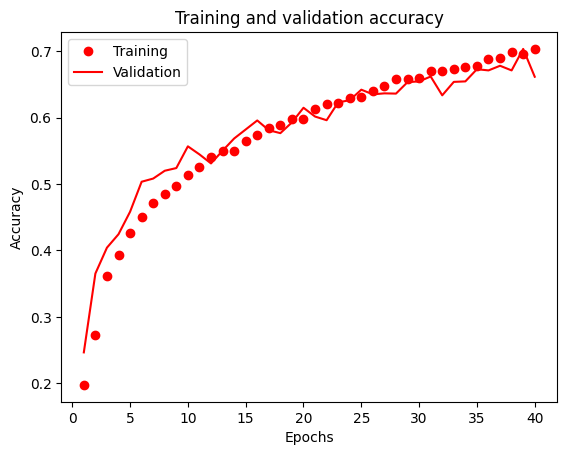

Ideal epoch for validation accuracy:  39 epochs
Validation accuracy:  0.7035675048828125
42/42 [==============================] - 19s 452ms/step
              precision    recall  f1-score   support

        cane       0.70      0.68      0.69       982
     cavallo       0.69      0.49      0.57       536
    elefante       0.76      0.56      0.64       300
    farfalla       0.57      0.92      0.70       416
     gallina       0.69      0.86      0.77       611
       gatto       0.66      0.28      0.39       361
       mucca       0.41      0.70      0.52       399
      pecora       0.59      0.58      0.59       433
       ragno       0.89      0.70      0.78       969
  scoiattolo       0.57      0.59      0.58       369

    accuracy                           0.66      5376
   macro avg       0.65      0.63      0.62      5376
weighted avg       0.68      0.66      0.65      5376



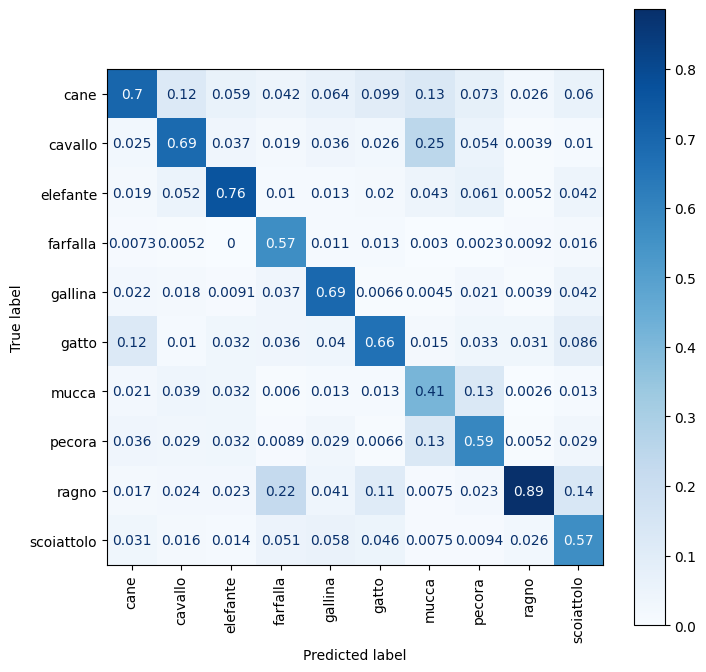

In [ ]:
evaluateModelsPerformance(inception_model_aug_5, inception_model_aug_5_history, processed_test_ds)

### Inception 8 Evaluation

As predicted the network kept learning more by training longer.
It looks like we can train even longer as it is still not overfitting.

Looks like data augmentation works really well with Incpetion networks as they have so much capacity to learn.

## Inception Network 9: Run same network for longer (50 epochs)

In [ ]:
inputLayer = tf.keras.Input(shape=(150, 150, 3))
rescalingLayer = tf.keras.layers.Rescaling(1./255)(inputLayer)

inceptBlock1 = inceptionModule(rescalingLayer, 30)
inceptBlock2 = inceptionModule(inceptBlock1, 30)
inceptBlock3 = inceptionModule(inceptBlock2, 30)
inceptBlock4 = inceptionModule(inceptBlock3, 30)

#ave pooling - factors by which to downscale - 2 times smaller
avgPooling = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(inceptBlock4)
flat = tf.keras.layers.Flatten()(avgPooling)
#classifier dense layers
dense = tf.keras.layers.Dense(1024, activation="relu")(flat)
dp1 = tf.keras.layers.Dropout(0.2)(dense)
dense2 = tf.keras.layers.Dense(1024, activation="relu")(dp1)
dp2 = tf.keras.layers.Dropout(0.2)(dense2)
dense3 = tf.keras.layers.Dense(1024, activation="relu")(dp2)
dp3 = tf.keras.layers.Dropout(0.2)(dense3)
dense4 = tf.keras.layers.Dense(1024, activation="relu")(dp3)
outputLayer = tf.keras.layers.Dense(num_classes, activation="softmax")(dense4)

inception_model_aug_6 = tf.keras.Model(inputs=inputLayer, outputs=outputLayer)

inception_model_aug_6.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

inception_model_aug_6_history = inception_model_aug_6.fit(
    processed_augmented_train_ds,
    validation_data=processed_val_ds,
    epochs=50
)

Epoch 1/50
148/148 [==============================] - 421s 3s/step - loss: 2.1613 - accuracy: 0.2093 - val_loss: 2.0030 - val_accuracy: 0.2666
Epoch 2/50
148/148 [==============================] - 418s 3s/step - loss: 1.9565 - accuracy: 0.3017 - val_loss: 1.7768 - val_accuracy: 0.3777
Epoch 3/50
148/148 [==============================] - 417s 3s/step - loss: 1.8039 - accuracy: 0.3725 - val_loss: 1.7274 - val_accuracy: 0.4031
Epoch 4/50
148/148 [==============================] - 418s 3s/step - loss: 1.7217 - accuracy: 0.4097 - val_loss: 1.6393 - val_accuracy: 0.4480
Epoch 5/50
148/148 [==============================] - 417s 3s/step - loss: 1.6531 - accuracy: 0.4304 - val_loss: 1.5671 - val_accuracy: 0.4708
Epoch 6/50
148/148 [==============================] - 416s 3s/step - loss: 1.5808 - accuracy: 0.4604 - val_loss: 1.5073 - val_accuracy: 0.4847
Epoch 7/50
148/148 [==============================] - 417s 3s/step - loss: 1.5197 - accuracy: 0.4803 - val_loss: 1.4331 - val_accuracy: 0.5153

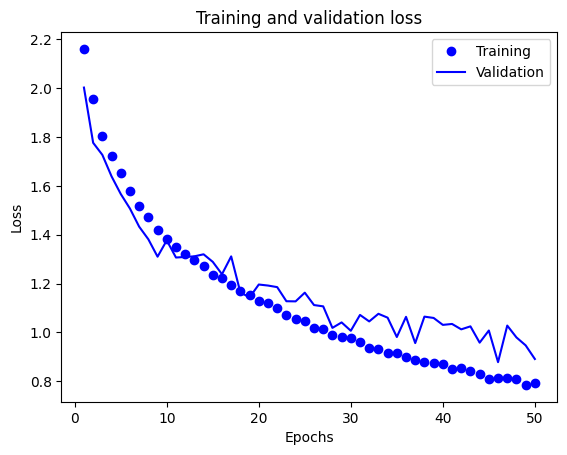

Ideal epoch for validation loss:  46 epochs
Validation loss:  0.8781924843788147


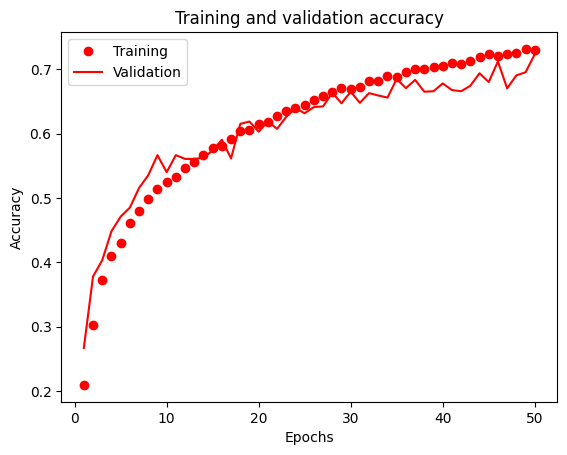

Ideal epoch for validation accuracy:  50 epochs
Validation accuracy:  0.7230599522590637
42/42 [==============================] - 18s 430ms/step
              precision    recall  f1-score   support

        cane       0.72      0.74      0.73       982
     cavallo       0.73      0.55      0.63       536
    elefante       0.68      0.69      0.69       300
    farfalla       0.69      0.88      0.77       416
     gallina       0.89      0.79      0.84       611
       gatto       0.65      0.52      0.58       361
       mucca       0.49      0.67      0.56       399
      pecora       0.58      0.76      0.66       433
       ragno       0.92      0.78      0.85       969
  scoiattolo       0.62      0.63      0.62       369

    accuracy                           0.72      5376
   macro avg       0.70      0.70      0.69      5376
weighted avg       0.73      0.72      0.72      5376



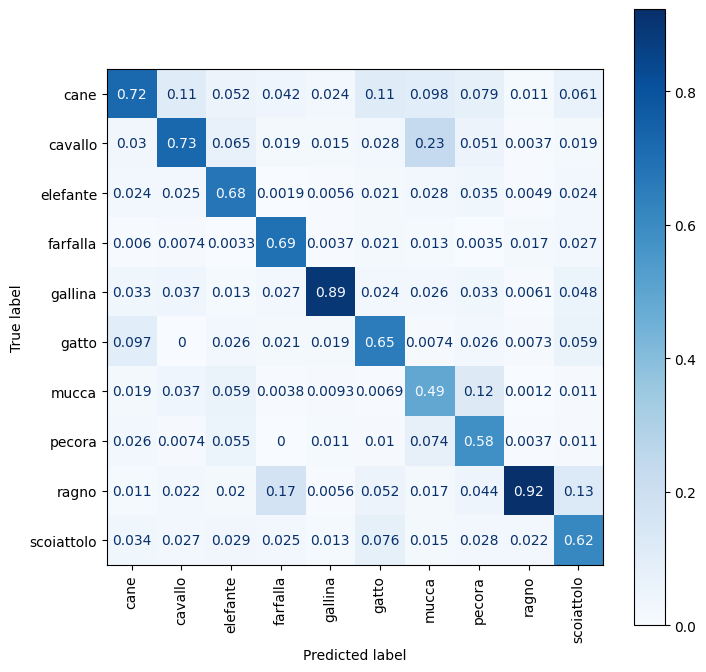

In [ ]:
evaluateModelsPerformance(inception_model_aug_6, inception_model_aug_6_history, processed_test_ds)

### Inception 10 Evaluation

This is the best performning Inception Network thus far with F1 Score of 72.

It actually looks like it could be train for even longer but training it is getting too expensive and time consuming so I will leave it here.


## DNN vs CNN vs Inception Performance

Here we compare the performances for the best performing models for each of the architectures:

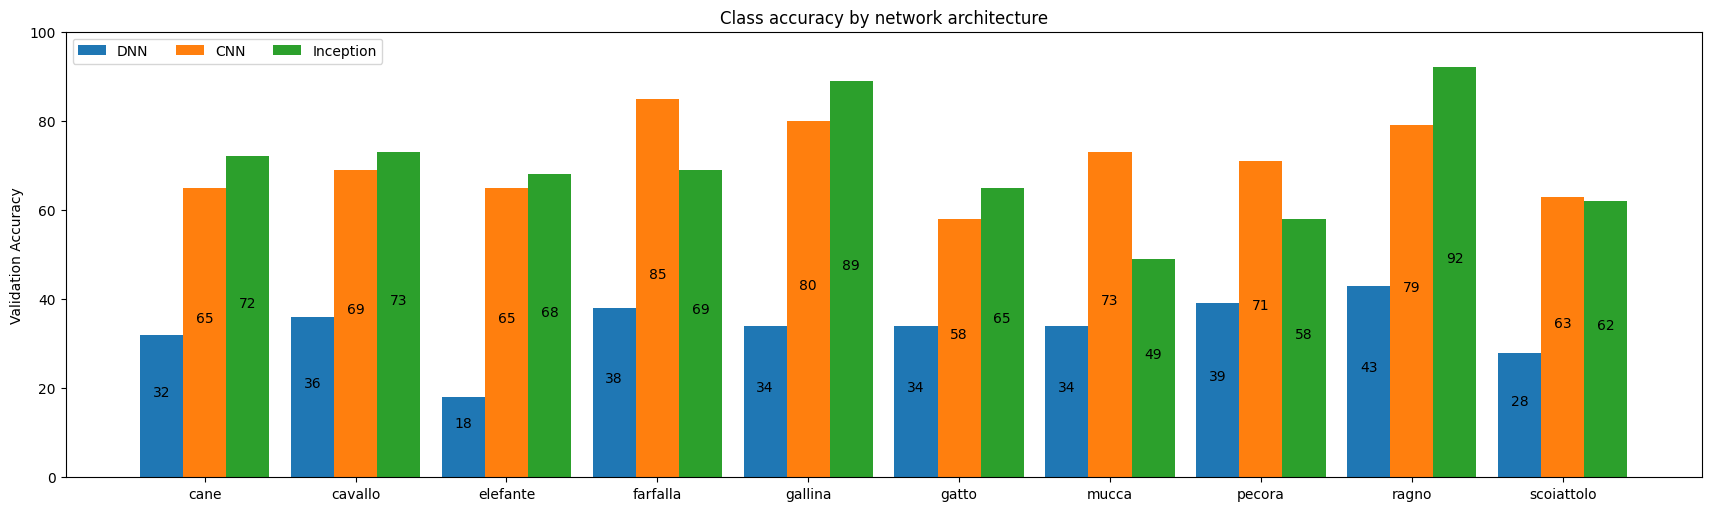

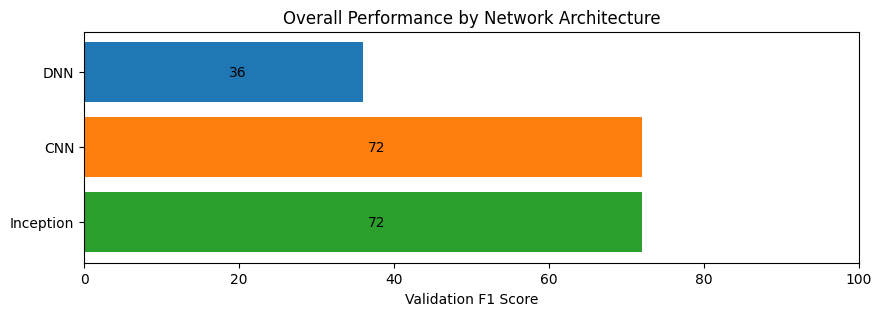

In [19]:
accuracies = {
    'DNN': (32, 36, 18, 38, 34, 34, 34, 39, 43, 28),
    'CNN': (65, 69, 65, 85, 80, 58, 73, 71, 79, 63),
    'Inception': (72, 73, 68, 69, 89, 65, 49, 58, 92, 62),
}

plotClassPerformanceComparison(accuracies)

names = ('DNN', 'CNN', 'Inception')
f1_scores = [36, 72, 72]

plotF1ScoreComparison(names, f1_scores)